# Executable code


Let's conduct a research on the impact of the solar activity upon the changes of the Earth temperature - the main aim is to compare the optained average temperatures for periods with high and low levels of solar activity and to found possible correlation between them.

We'll assume that there are 52 weeks in the year and calculate daily and weekly average temperature between 1818 and 2018 years in three european cities, similar to the Le Mouël's article entitled as "A solar pattern in the longest temperature series from three stations in Europe".

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import rc

plt.rc("text", usetex=True)

WEEK_LENGTH, WEEKS_NUMBER = 7, 52
MONTHS_NUMBER, DAYS_NUMBER = 12, 365
BEGIN, END = 1818, 2018
FOUR_YEARS = 1461
YEAR_DAYS = np.array(range(1, DAYS_NUMBER + 1))

months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

DPI = 80
SIZE_X, SIZE_Y = 15, 5

Additional functions for working with dates and files are to be found here.

In [2]:
def GetDayNumber(month, day):
    day_number = day - 1
    for i in range(month - 1):
        day_number += months[i]
    return day_number

def GetDate(day):
    month = 0
    while month < len(months) and day >= months[month]:
        day -= months[month]
        month += 1
    return (month + 1, day + 1)

def GetWeekNumber(day):
    return min(WEEKS_NUMBER - 1, day // WEEK_LENGTH)

def GetFileName(city, case):
    suf = {"max": "X", "min": "N", "mean": "G"}
    return "T{}_{}_formatted.txt".format(suf[case], city)

def GetPicName(city, case, suf):
    letter = {"max": "X", "min": "N", "mean": "G"}
    return "pic/{}_{}_{}.jpg".format(city, letter[case], suf)

As a start let's constract a line graph shows average daily solar activity throughout a 4-year period.

In [3]:
f_in = open("solar_data.txt", "r")

queue, day_spots, years, dates = [], [], [], []
year_spots = np.zeros(END - BEGIN + 1)
first_date, date_by_number = dict(), dict()

cur_sum, amount_measurements = 0, 0

for line in f_in:
    row = list(map(float, line.split()[:7]))
    year, month, day, spots = int(row[0]), int(row[1]), int(row[2]), row[4]
    
    if not row[-1]: # no measurements in this day
        queue.append((year, month, day, -1))
    else:
        amount_measurements += 1
        queue.append((year, month, day, spots))
        cur_sum += spots
    
    if len(queue) == FOUR_YEARS:
        n = len(day_spots) # number of the measurements before current
        year, month, day = queue[FOUR_YEARS // 2][:3]
        cur_spots = cur_sum / amount_measurements
        if (month, day) != (2, 29): # if middle != 29th, February
            year_spots[year - BEGIN] += cur_spots
            if year not in first_date:
                first_date[year] = n
            date_by_number[n] = (year, GetDayNumber(month, day))
            day_spots.append(cur_spots)
            
            if (year - BEGIN) % 20 == 0 and GetDayNumber(month, day) == DAYS_NUMBER // 2:
                years.append(year)
                dates.append(n)
        
        if queue[0][-1] >= 0: # if any measurement was taken in the day on the top of queue
            cur_sum -= queue[0][-1]
            amount_measurements -= 1
        queue.pop(0) 
f_in.close()

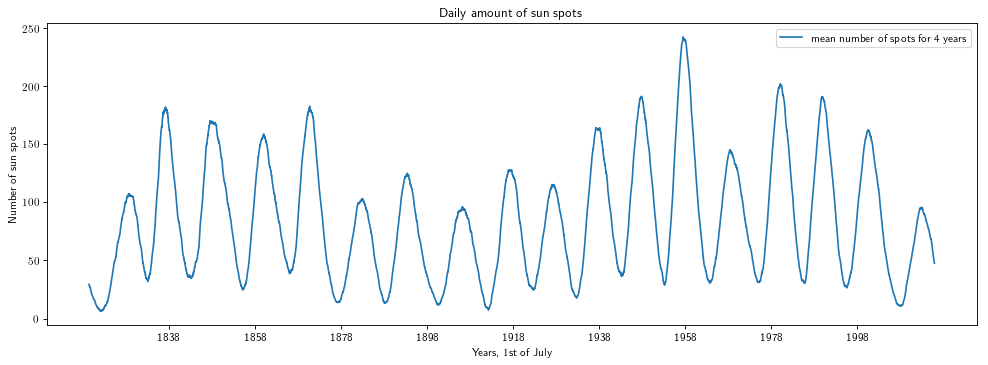

In [4]:
fig = plt.figure(dpi=DPI, figsize=(SIZE_X, SIZE_Y))
plt.title("Daily amount of sun spots")
plt.xlabel("Years, $1$st of July")
plt.ylabel("Number of sun spots")

plt.xticks(dates, years)
plt.plot(np.array(range(len(day_spots))), 
         np.array(day_spots), 
         label="mean number of spots for 4 years")
plt.legend(loc="best")

fig.savefig("pic/cycles.jpg")
plt.show()

Let's find the days with the lowest solar activity in keeping with the years with the minimum amount of sun spots.

In [5]:
year = 1822
years_of_minimum = [year]    

while year < END:
    while year < END and year_spots[year - BEGIN] <= year_spots[year - BEGIN + 1]:
        year += 1
    while year < END and year_spots[year - BEGIN] >= year_spots[year - BEGIN + 1]:
        year += 1
    years_of_minimum.append(year)

days_of_minimum = []
for year in years_of_minimum[:-1]:
    start = first_date[year - 1] if year != years_of_minimum[0] else 0
    finish = first_date[year + 2]
    min_day = start
    for day in range(start, finish):
        if day_spots[day] < day_spots[min_day]:
            min_day = day
    days_of_minimum.append(min_day)

Cycles of the solar activity should be divided into periods of low or high activity according to parameter denotes the share of the days which can be refered to each period.

In [6]:
def GetActivityLevels(alpha):
    low_activity = set()
    high_activity = set()

    for i in range(len(days_of_minimum) - 1):
        start, finish = days_of_minimum[i], days_of_minimum[i + 1]
        spots = []
        for day in range(start, finish):
            spots.append((day_spots[day], day))
        spots.sort()
    
        for j in range(int(len(spots) * alpha)):
            day = spots[j][1]
            if day in date_by_number:
                low_activity.add(date_by_number[day])
            day = spots[len(spots) - 1 - j][1]
            if day in date_by_number:
                high_activity.add(date_by_number[day])

    return (low_activity, high_activity)

Let's draw a line graph illustrating mean temperatures taken of the days with high and low solar activity and normalized average difference between them througout 21 days.

In [7]:
def GetNormalizedMean(first, second):
    return [(np.mean(first[i]) - np.mean(second[i])) / 
            (np.std(first[i]) ** 2 + np.std(second[i]) ** 2) ** 0.5 
            for i in range(len(first))]

def GetRandomShift():
    return np.random.uniform(-0.05, 0.05)

In [8]:
def DrawMinMaxTemperatures(city, case, low_activity, high_activity):    
    pic_name = GetPicName(city, case, "average_diff")
    measurements_low = [[] for i in range(DAYS_NUMBER)]
    measurements_high = [[] for i in range(DAYS_NUMBER)]
    
    f_in = open(GetFileName(city, case), "r")
    for line in f_in:
        row = line.split(",")
        date, temperature = row[2], float(row[3]) / 10 + GetRandomShift()
        year, month, day = int(date[:4]), int(date[4:6]), int(date[6:])
        
        day = GetDayNumber(month, day)
        if (year, day) in low_activity:
            measurements_low[day].append(temperature)
        elif (year, day) in high_activity:
            measurements_high[day].append(temperature)
    
    mean_low = [np.mean(measurements_low[day]) for day in range(DAYS_NUMBER)]
    mean_high = [np.mean(measurements_high[day]) for day in range(DAYS_NUMBER)]

    fig = plt.figure(dpi=DPI, figsize=(SIZE_X, SIZE_Y))
    ax = plt.axes()
    ax.yaxis.grid(True)
    plt.title(city + " average " + full[case] + 
              " $t^{\circ}$ based on 4-year mean solar activity level")
    plt.xlabel("Number of days since January, $1$st")
    plt.ylabel("Mean t, $C^{\circ}$", rotation="horizontal", labelpad=35)    
    plt.plot(YEAR_DAYS, 
             mean_low, 
             color="blue", 
             label="low level of solar activity")
    plt.plot(YEAR_DAYS, 
             mean_high, 
             color="red", 
             label="high level of solar activity")
    plt.legend(loc="best")
    fig.savefig("pic/" + city + "_mean_" + case + "_temperature.jpg")

    delta_temp = GetNormalizedMean(measurements_high, measurements_low)    
    fig = plt.figure(dpi=DPI, figsize=(SIZE_X, SIZE_Y))
    ax = plt.axes()
    ax.yaxis.grid(True)
    plt.title("Normalized " + full[case] + " temperature difference in " + city)
    plt.xlabel("Number of days since January, $1$st")
    plt.ylabel("$\\frac{\Delta t}{\sqrt{s_1^2 + s_2^2}}$", 
               rotation='horizontal', labelpad=10, fontsize=17)
    plt.plot(YEAR_DAYS, delta_temp, color="grey")
    plt.show()
    fig.savefig(pic_name)
    f_in.close()

In [9]:
def PrintDifferenceDayTemperature(city, case, alpha, low_activity, high_activity):
    pic_name = GetPicName(city, case, "diff_" + str(int(alpha * 100)))
    measurements_low = [[] for i in range(DAYS_NUMBER)]
    measurements_high = [[] for i in range(DAYS_NUMBER)]

    f_in = open(GetFileName(city, case), "r")
    for line in f_in:
        row = line.split(",")
        date, temperature = row[2], float(row[3]) / 10
        year, month, day = int(date[:4]), int(date[4:6]), int(date[6:])

        day = GetDayNumber(month, day)
        if (year, day) in low_activity:
            measurements_low[day].append(temperature)
        elif (year, day) in high_activity:
            measurements_high[day].append(temperature)

    mean_low = [np.median(measurements_low[day]) for day in range(DAYS_NUMBER)]
    mean_high = [np.median(measurements_high[day]) for day in range(DAYS_NUMBER)]
    delta_temp = (np.array(mean_high) - np.array(mean_low))
    median_delta = np.median(delta_temp)

    m_low = np.array([len(measurements_low[day]) for day in range(DAYS_NUMBER)])
    m_high = np.array([len(measurements_high[day]) for day in range(DAYS_NUMBER)])

    N = 10  # averaging "width"
    delta_temp = np.concatenate((delta_temp, delta_temp, delta_temp))
    mean_delta = [np.mean(delta_temp[(i - N):(i + N + 1)]) 
                  for i in range(DAYS_NUMBER, DAYS_NUMBER * 2)]
    
    fig = plt.figure(dpi=DPI, figsize=(SIZE_X, SIZE_Y))
    ax1 = plt.axes()
    ax1.yaxis.grid(True)
    plt.title(city + " average " + full[case] + " temperature differences")
    plt.xlabel("Number of days since January, $1$st")
    ax1.set_ylabel("$\Delta t$, $C^{\circ}$", rotation="horizontal", labelpad=10)
    ax2 = ax1.twinx()
    ax2.set_ylabel("Measurements", rotation="horizontal", labelpad=30)
    difference_label = "$\\alpha$ = " + str(alpha) + ", mean $\Delta$ = " + str(median_delta)
    line1 = ax1.plot(YEAR_DAYS, 
                    mean_delta, 
                    label=difference_label,
                    color="grey")
    line2 = ax2.plot(YEAR_DAYS, 
                    m_low, 
                    label="low level of solar activity", 
                    color="blue")
    line3 = ax2.plot(YEAR_DAYS, 
                    m_high, 
                    label="high level of solar activity",
                    color="red")
    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc="upper right")
    plt.show()
    fig.savefig(pic_name)
    f_in.close()

Selection contains three stations located in european cities: Bologna (Italy), Prague (Czech Republic) and Uccle (Belgium).

In [10]:
cities = ["Bologna", "Prague", "Uccle"]   # попробуем взять два города, располагающиеся совсем на одной широте
cases = {"Bologna": ["max", "min", "mean"], 
         "Prague": ["max", "min", "mean"], 
         "Uccle": ["max", "min"],
         "Jena": ["max", "min", "mean"]}
full = {"max": "maximum", "min": "minimum", "mean": "mean"}
parameters = [0.5, 0.25, 0.1]

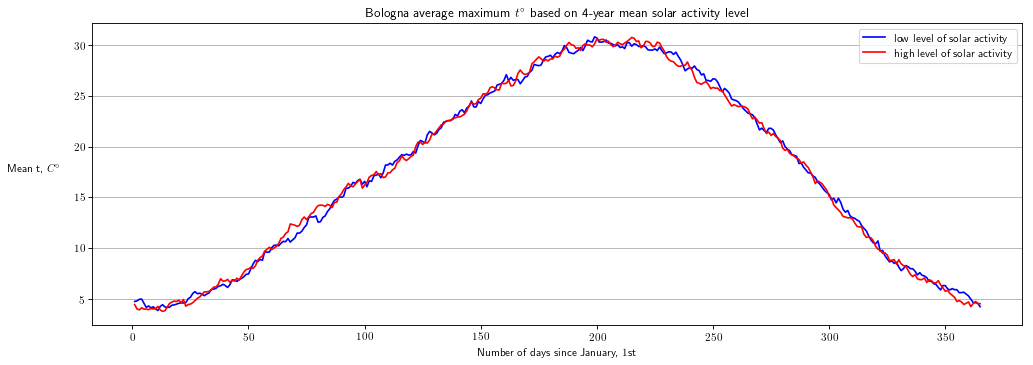

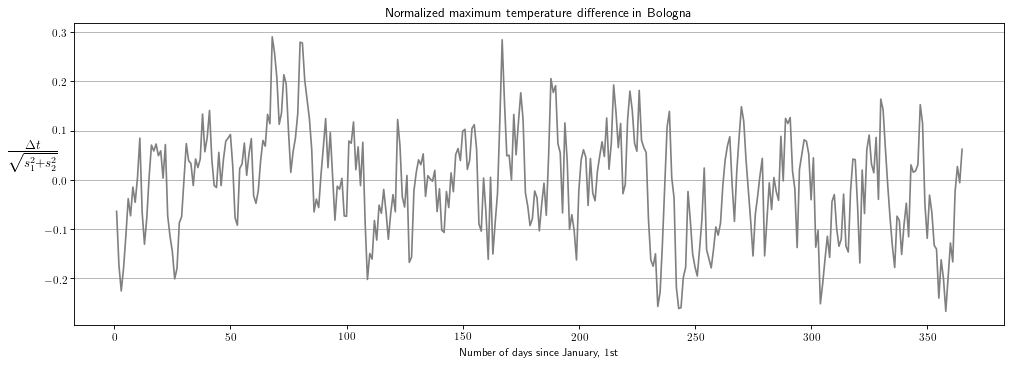

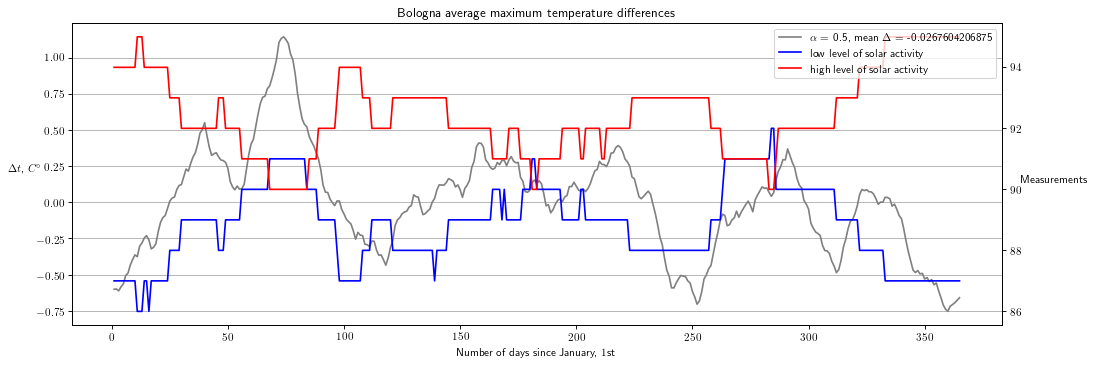

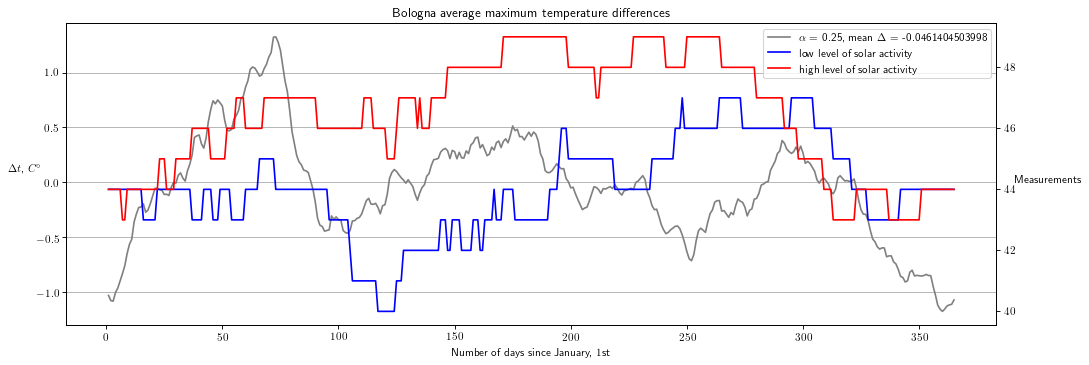

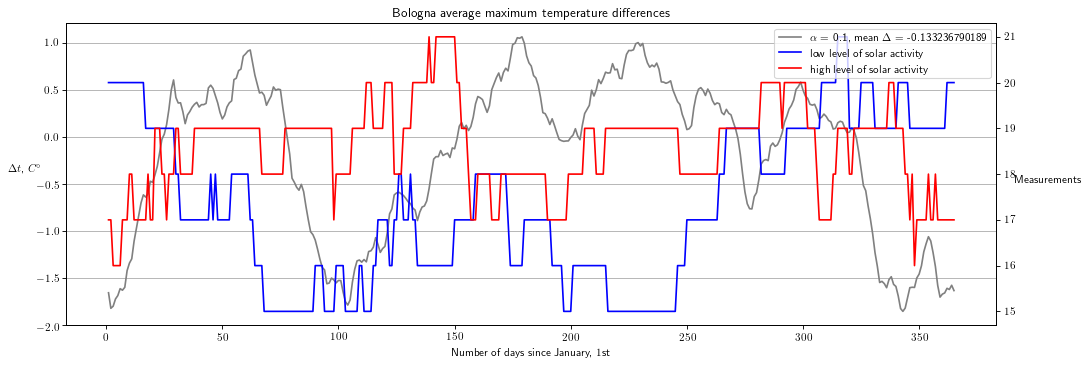

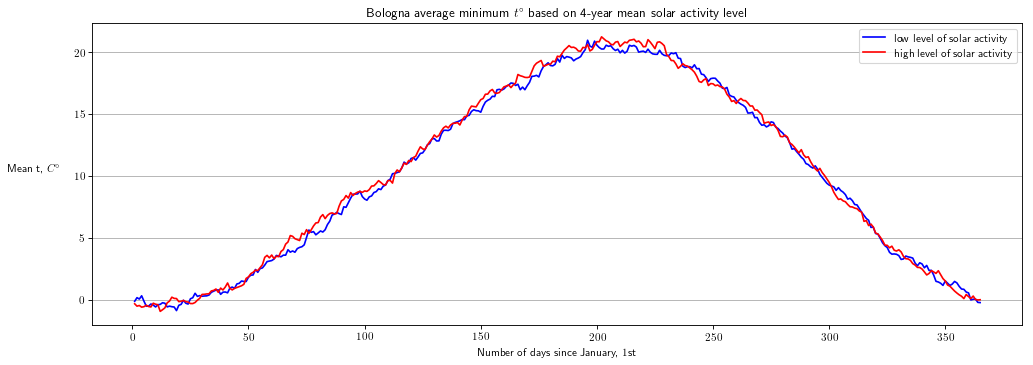

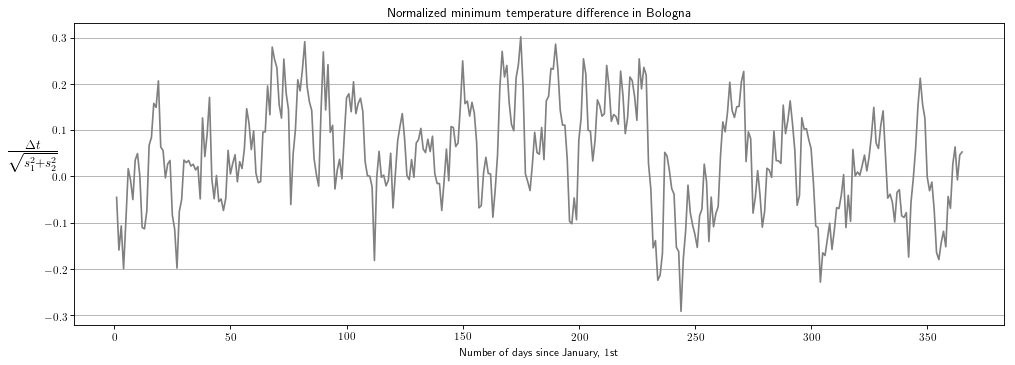

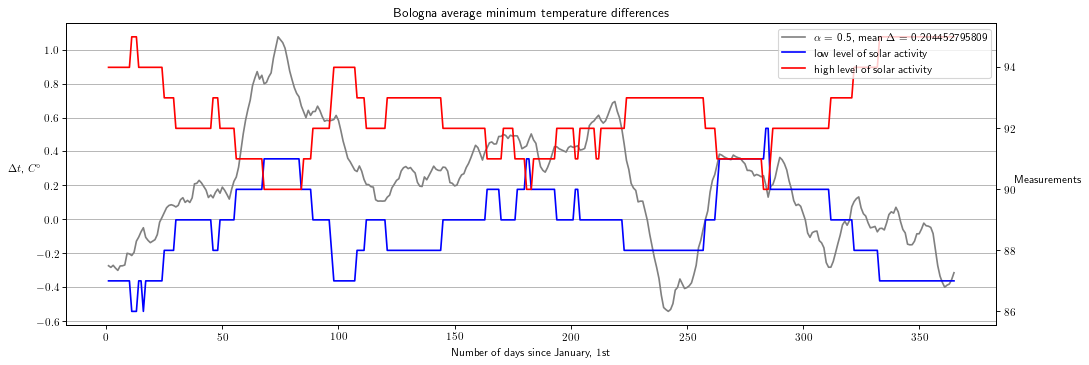

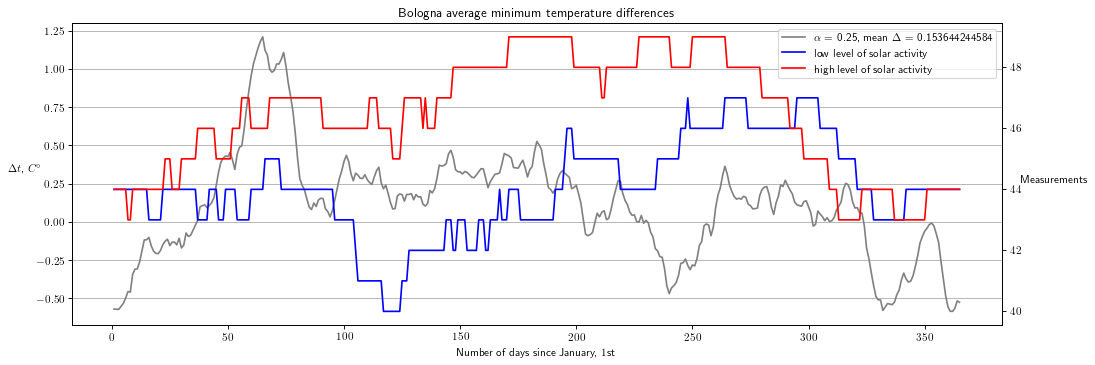

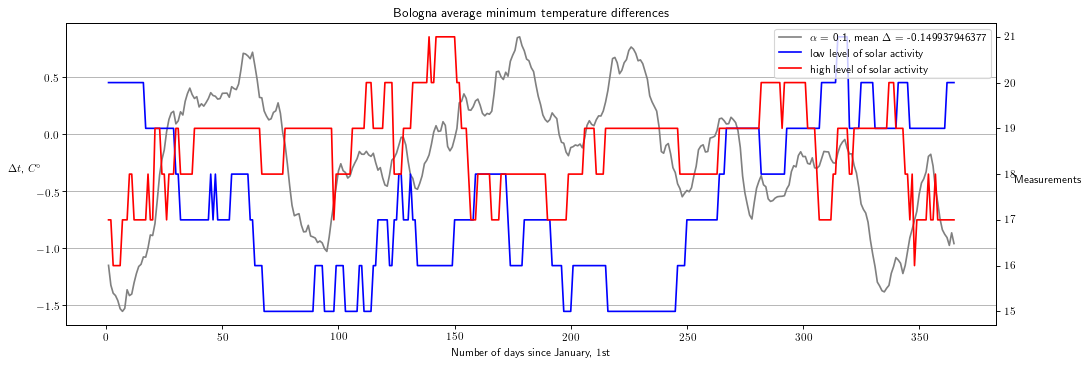

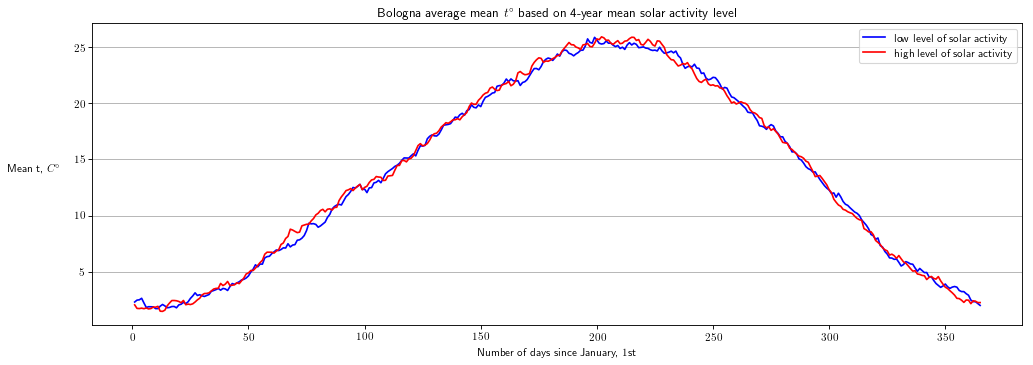

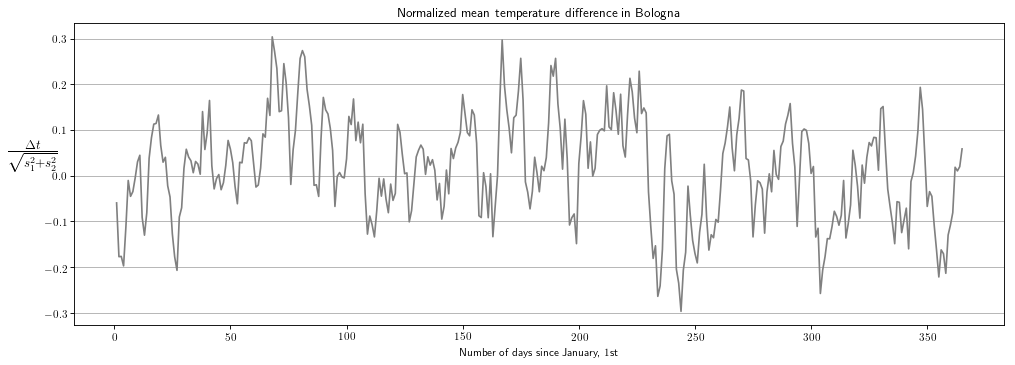

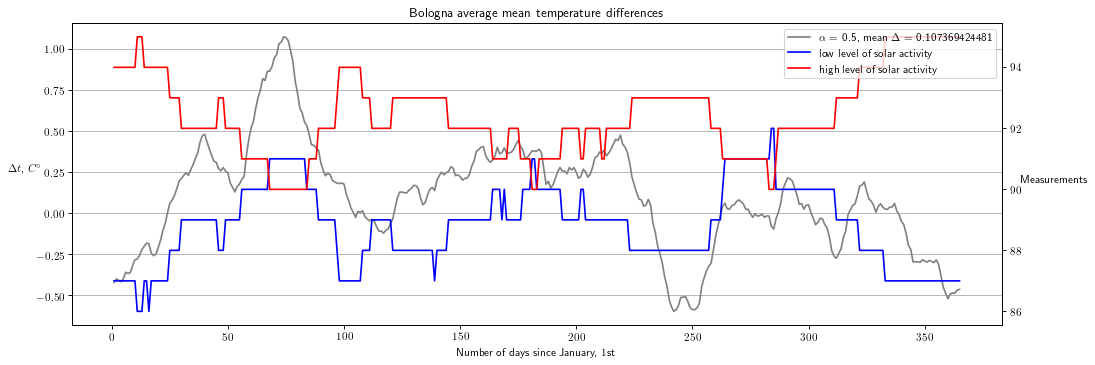

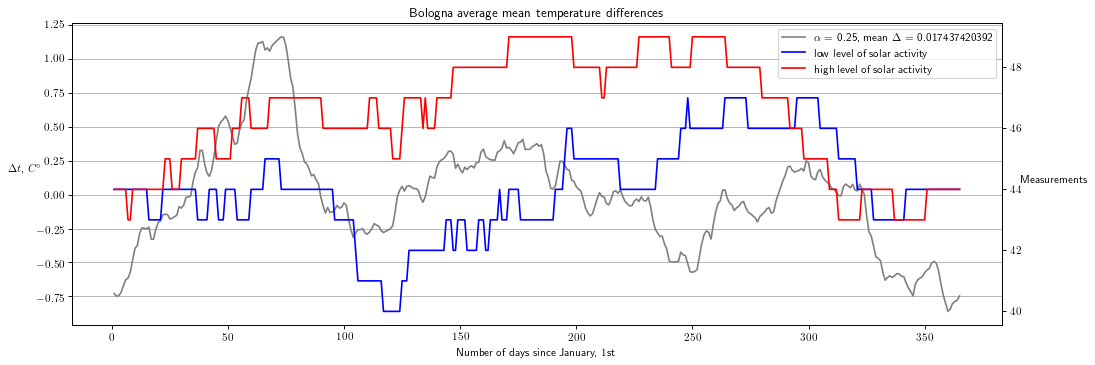

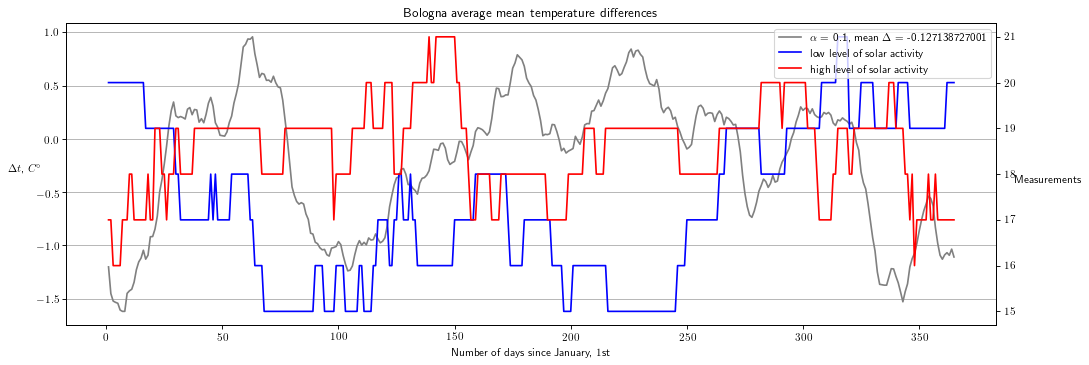

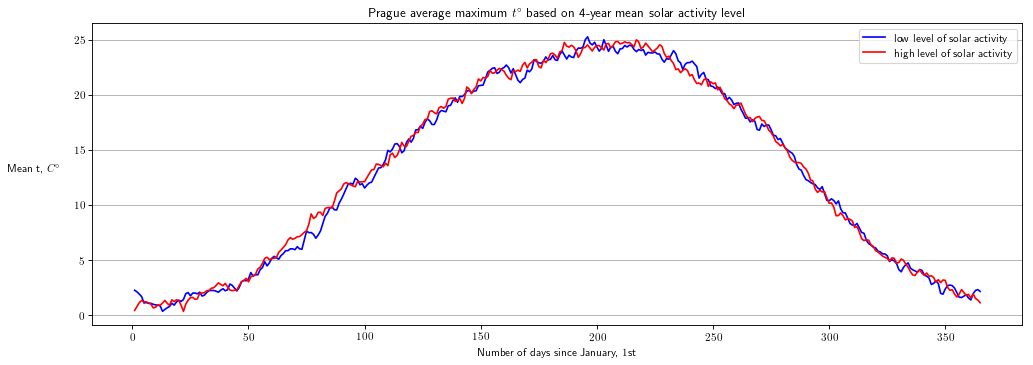

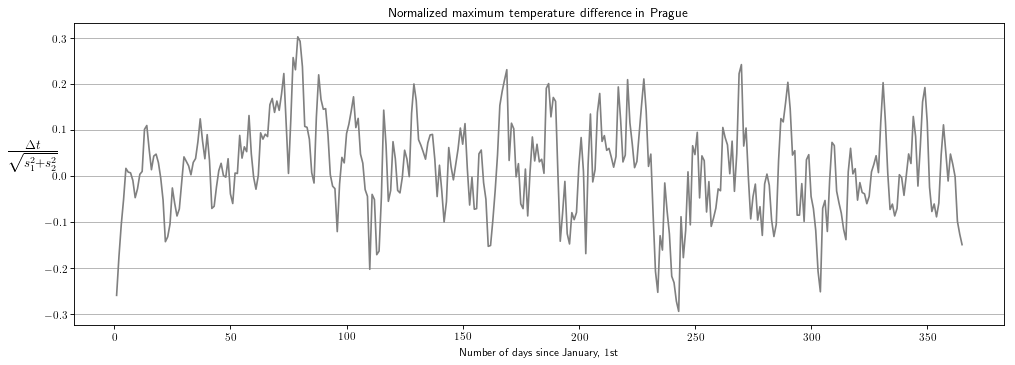

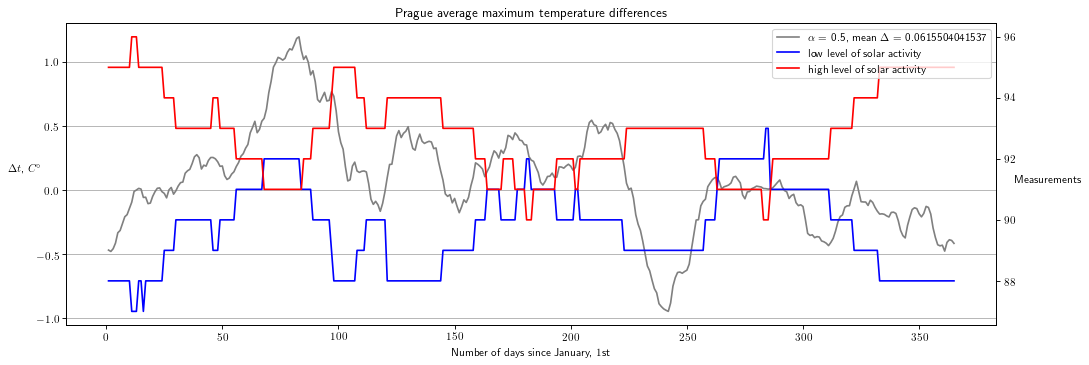

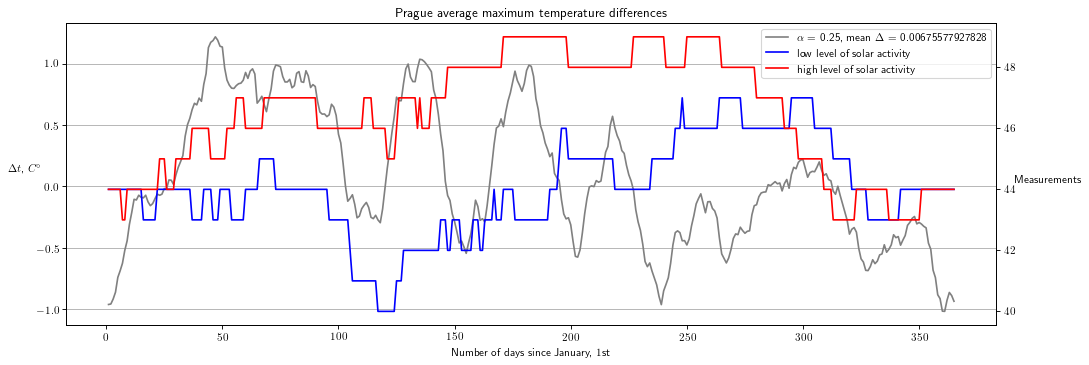

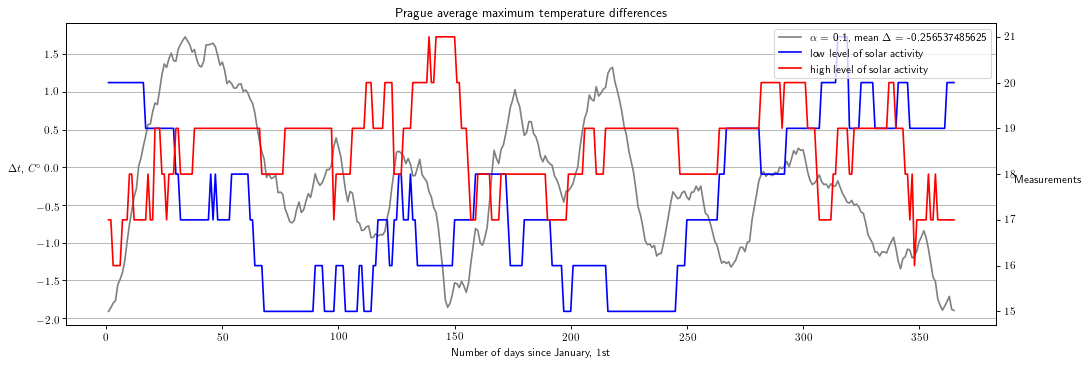

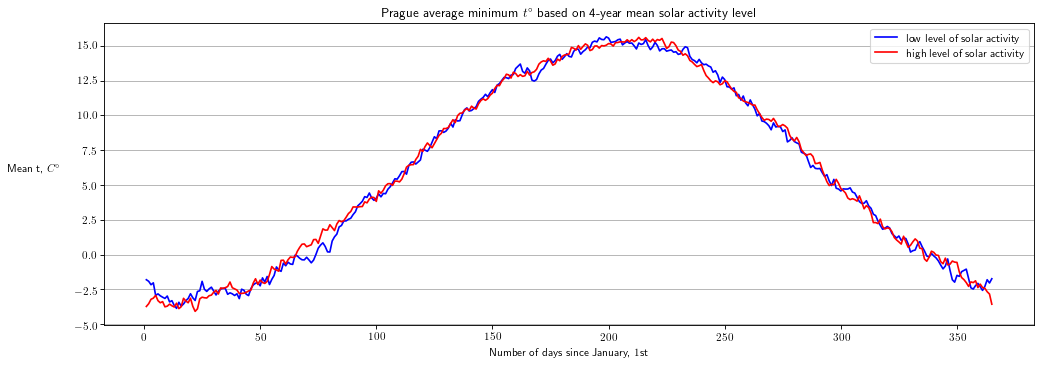

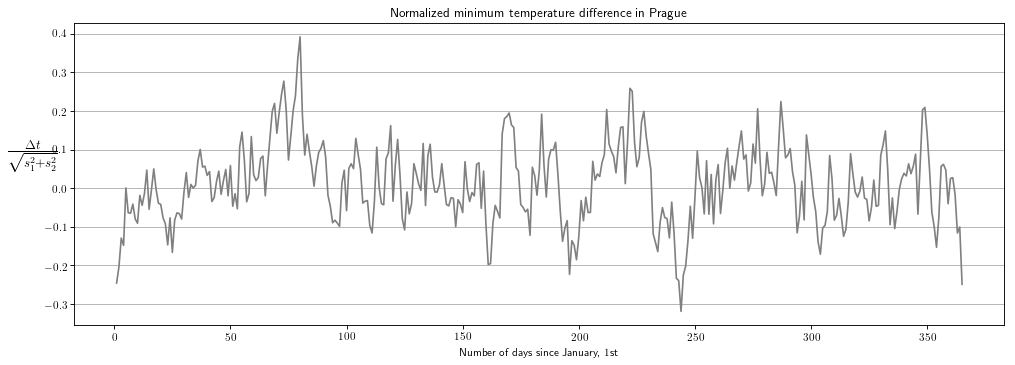

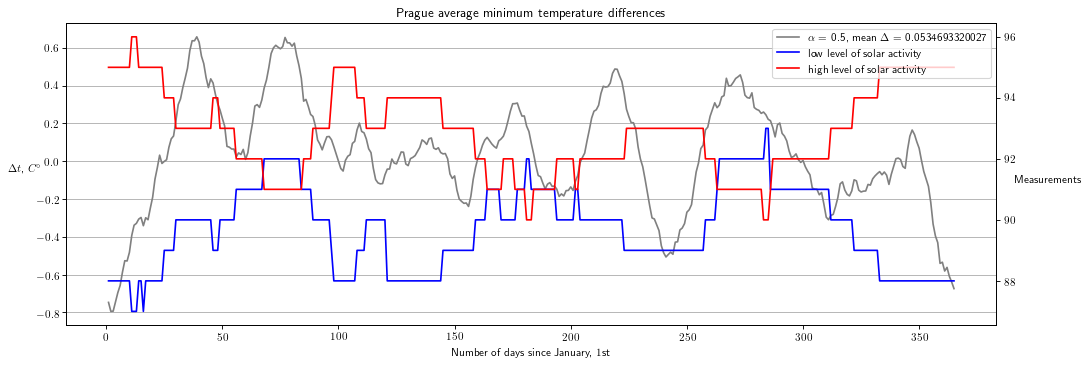

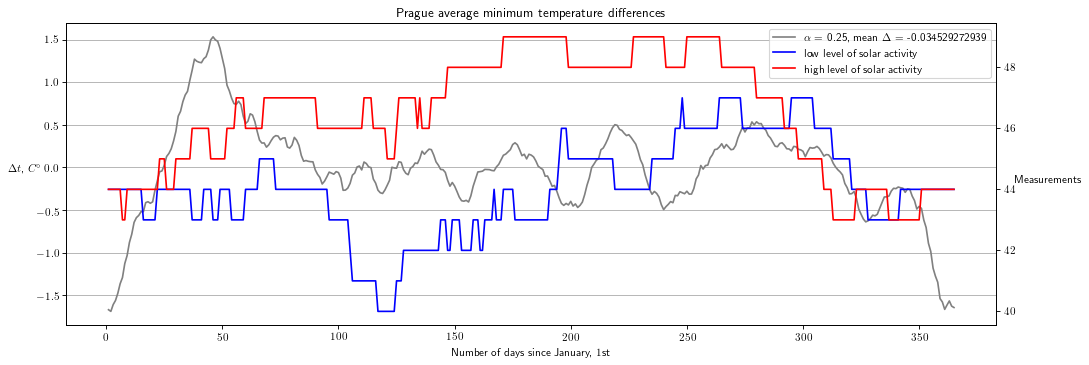

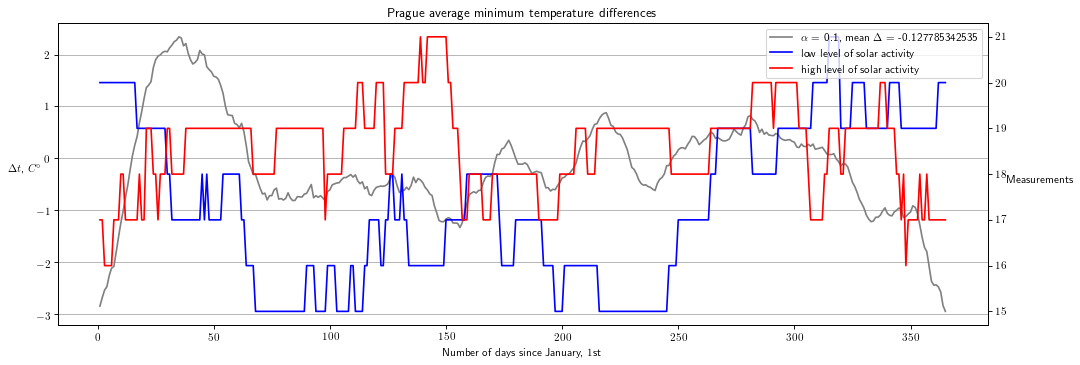

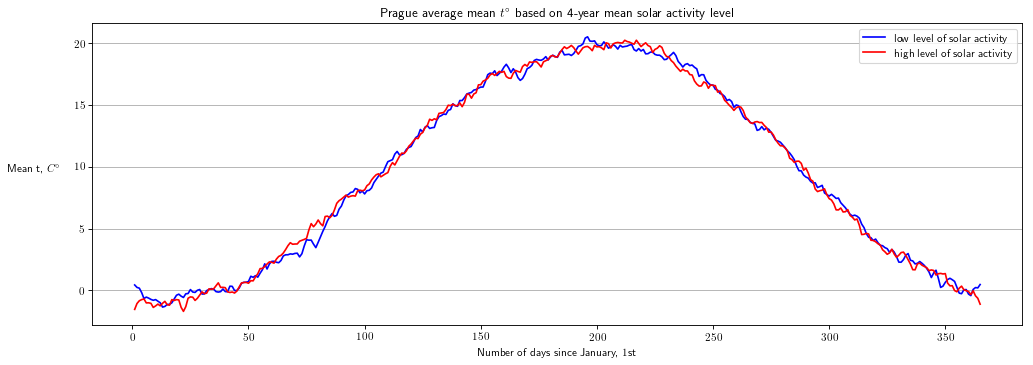

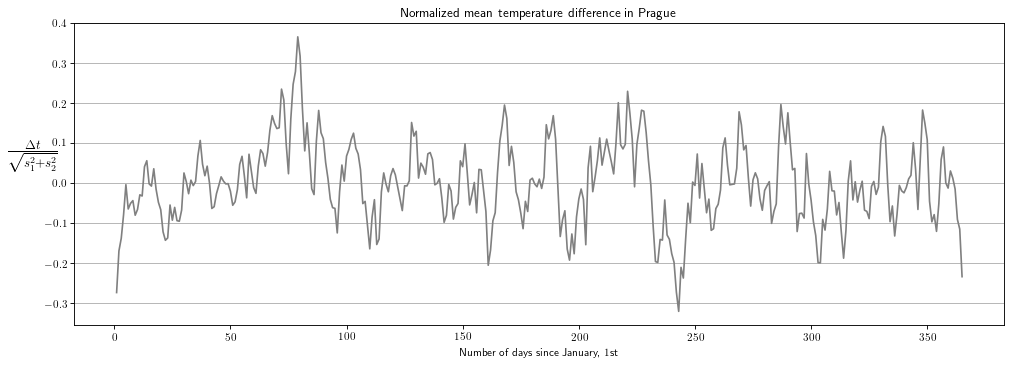

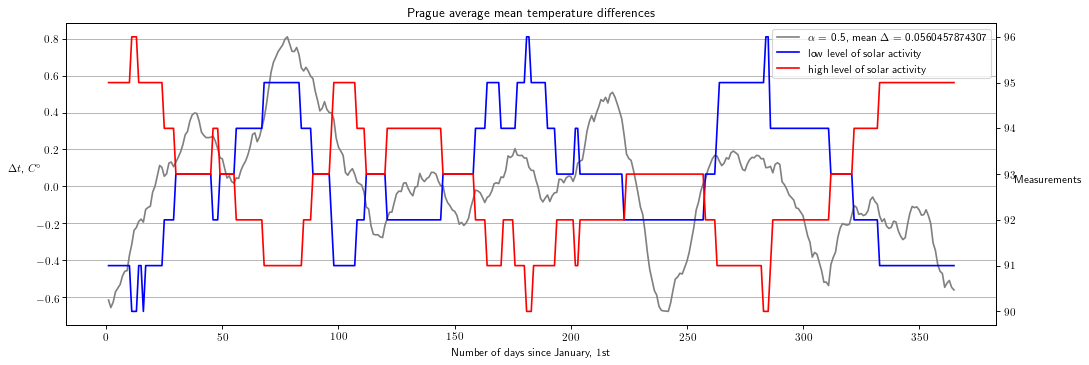

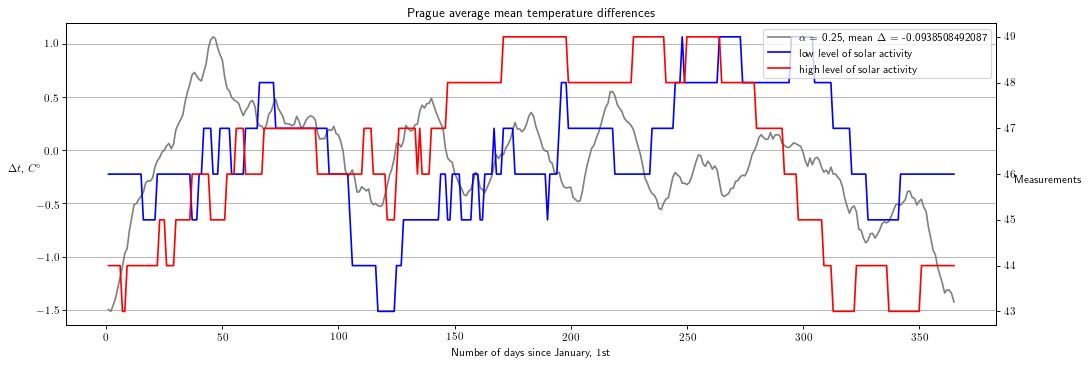

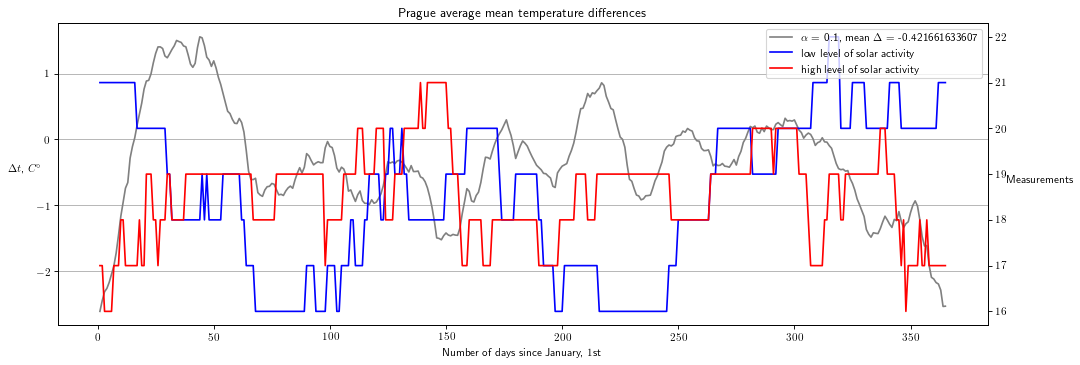

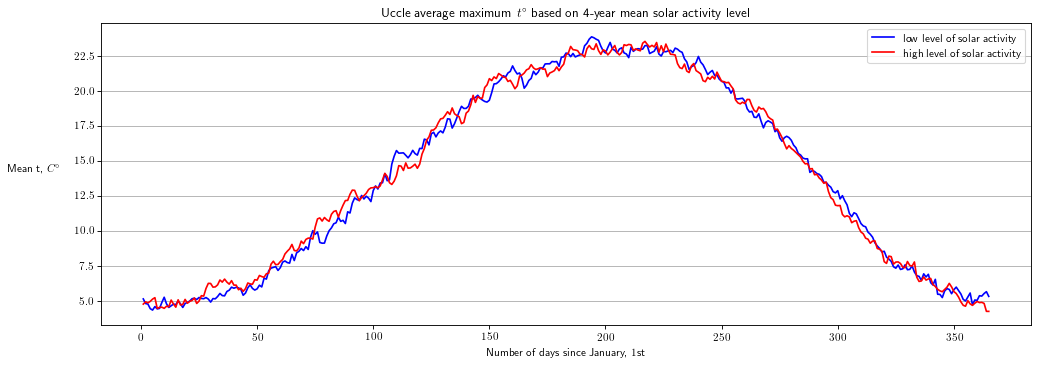

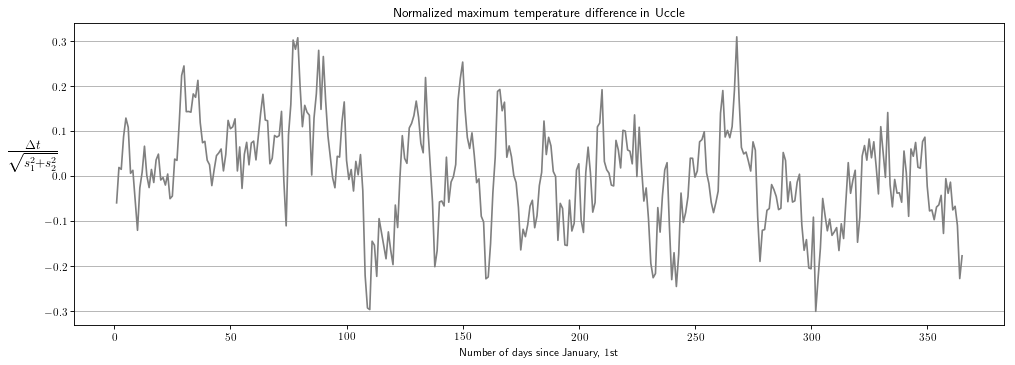

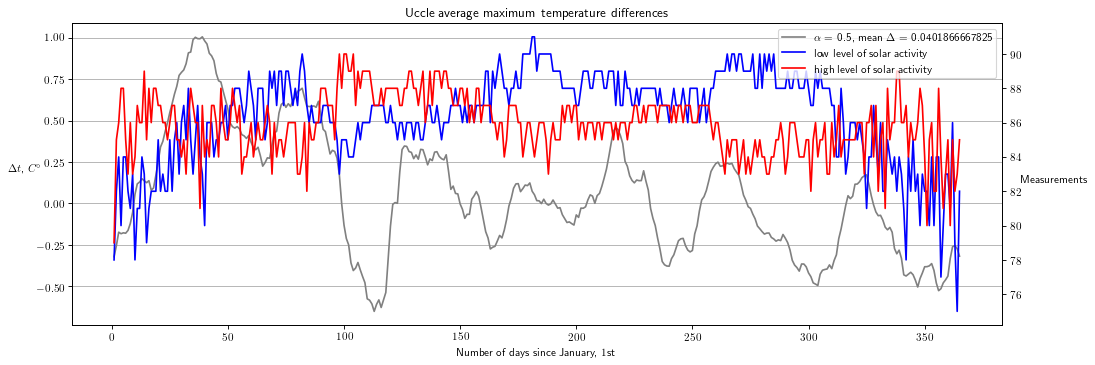

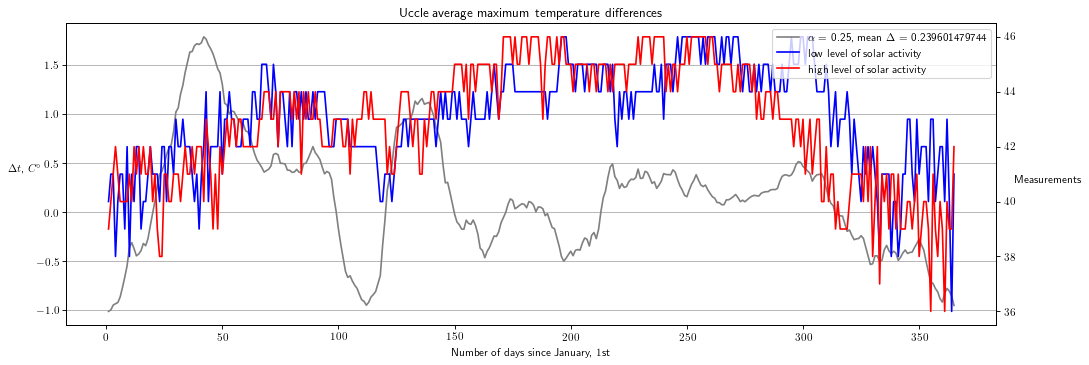

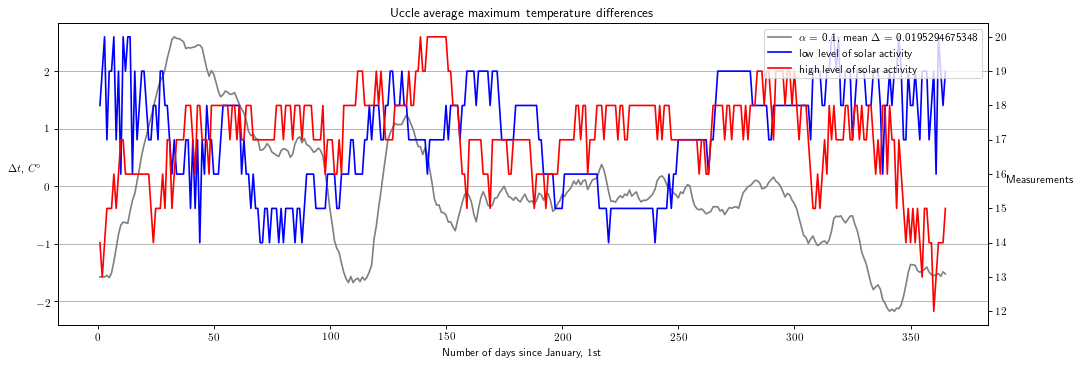

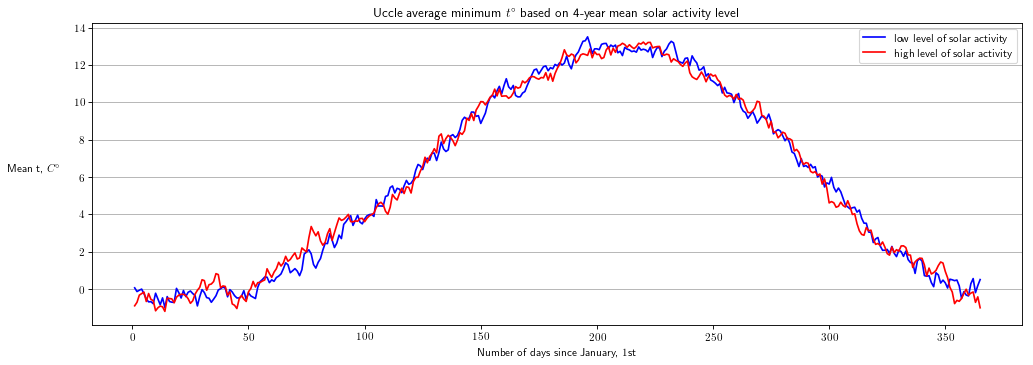

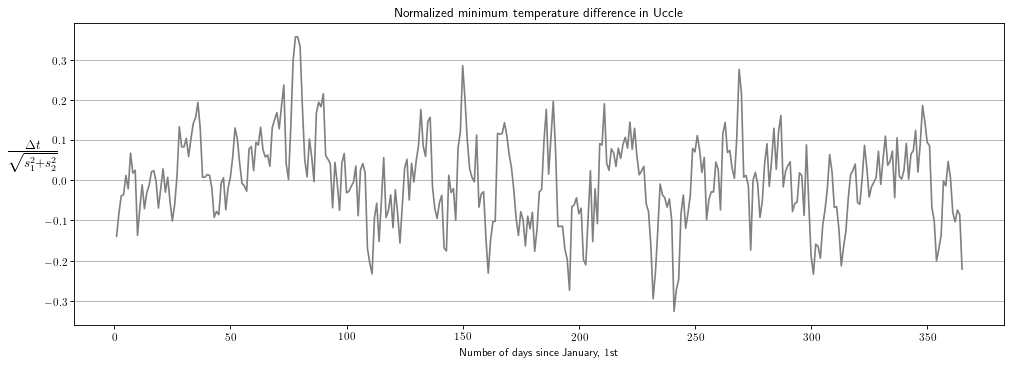

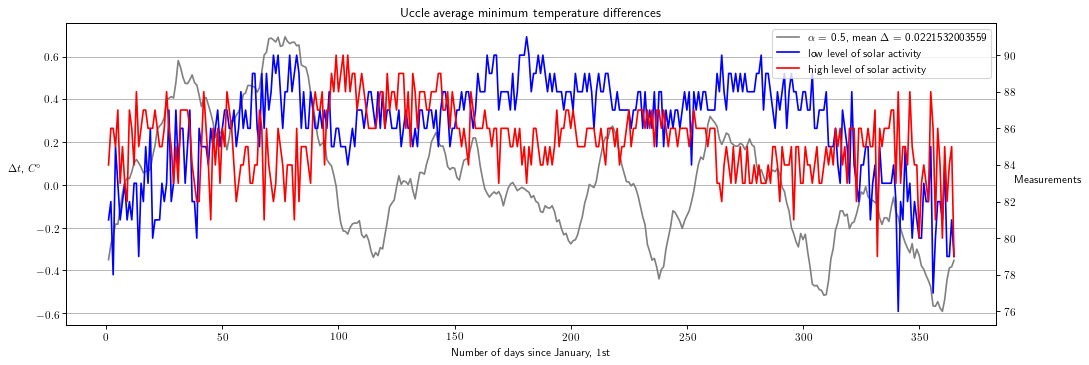

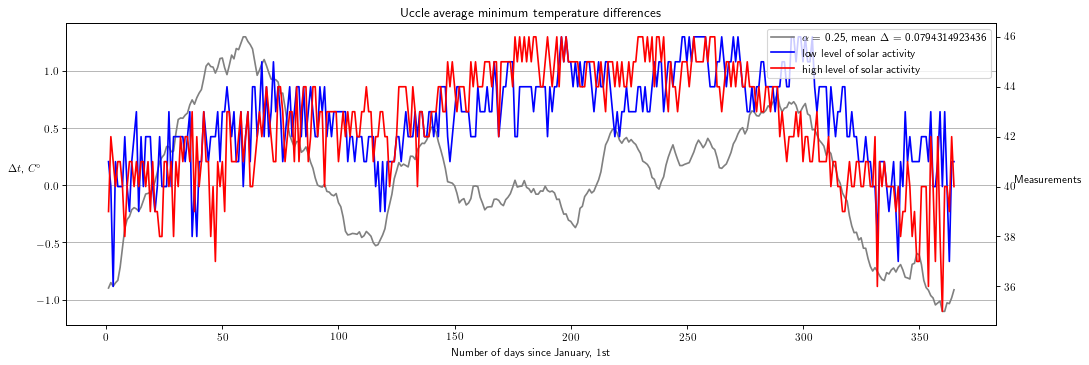

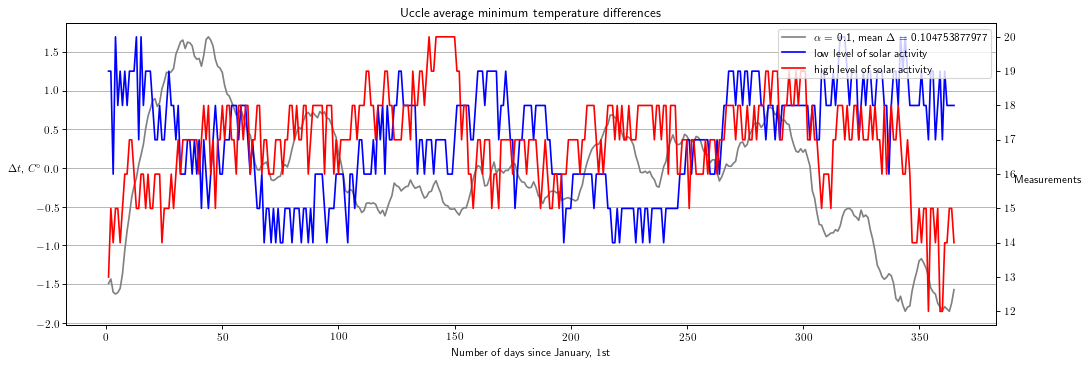

In [11]:
for city in cities:
    for case in cases[city]:
        low_activity, high_activity = GetActivityLevels(0.5)
        DrawMinMaxTemperatures(city, case, low_activity, high_activity)
        for alpha in parameters:
            low_activity, high_activity = GetActivityLevels(alpha)
            PrintDifferenceDayTemperature(city, case, alpha, low_activity, high_activity)

In [12]:
def MeanDiff(city, case, year_begin, year_end, low_activity, high_activity):
    day_measurements_low = [np.array([]) for i in range(DAYS_NUMBER)]
    day_measurements_high = [np.array([]) for i in range(DAYS_NUMBER)]

    week_measurements_low = [np.array([]) for i in range(WEEKS_NUMBER)]
    week_measurements_high = [np.array([]) for i in range(WEEKS_NUMBER)]
    
    f_in = open(GetFileName(city, case), "r")
    all_temp = []
    
    for line in f_in:
        row = line.split(",")
        date, temperature = row[2], float(row[3]) / 10 + GetRandomShift()
        cur_year, month, day = int(date[:4]), int(date[4:6]), int(date[6:])
        
        day = GetDayNumber(month, day)
        week = GetWeekNumber(day)
        if year_begin <= cur_year < year_end:
            if (cur_year, day) in low_activity:
                week_measurements_low[week] = np.append(week_measurements_low[week], temperature)
                day_measurements_low[day] = np.append(day_measurements_low[day], temperature)
                all_temp.append(temperature)
            elif (cur_year, day) in high_activity:
                week_measurements_high[week] = np.append(week_measurements_high[week], temperature)
                day_measurements_high[day] = np.append(day_measurements_high[day], temperature)
                all_temp.append(temperature)
        elif cur_year >= year_end:
            break
    f_in.close()
    day_delta_temp = GetNormalizedMean(day_measurements_high, day_measurements_low)
    week_delta_temp = GetNormalizedMean(week_measurements_high, week_measurements_low)
    
    temp = np.mean(all_temp)
    return (np.median(day_delta_temp), np.median(week_delta_temp), temp)

Let's study average values of temperature difference between days with different level of solar activity in a floating window depending on the $\alpha$, however it should be kept in mind that too little data has been gained for the small parameter's value.

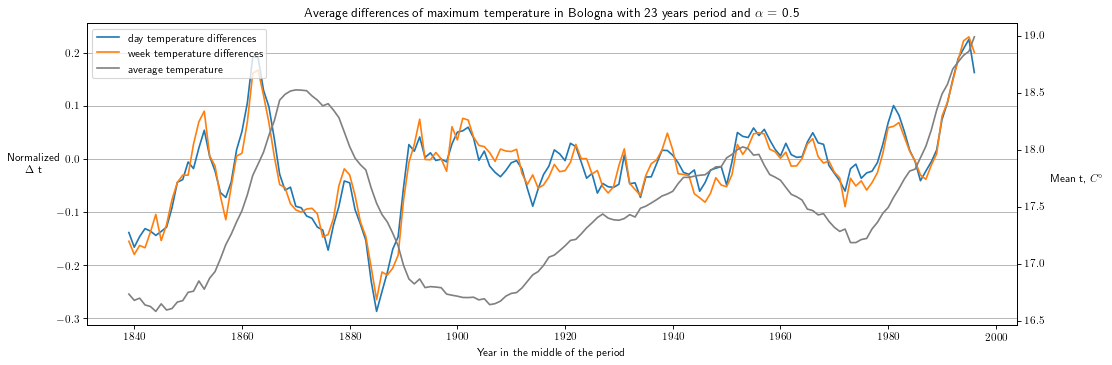

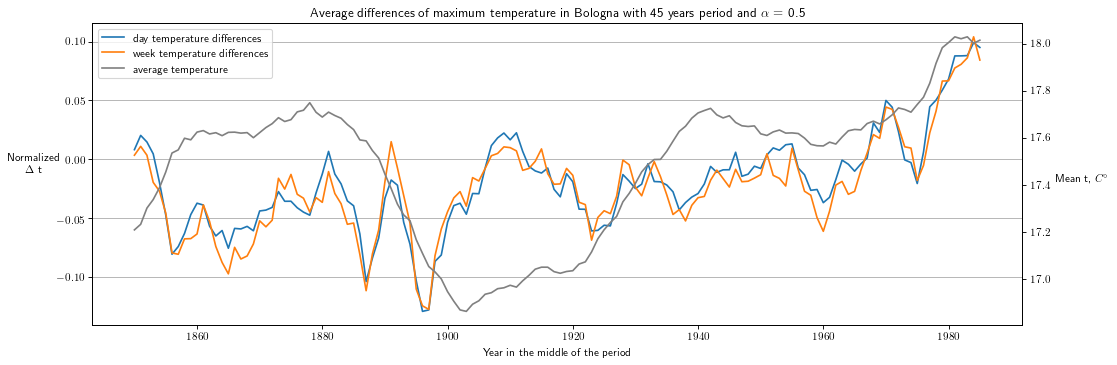

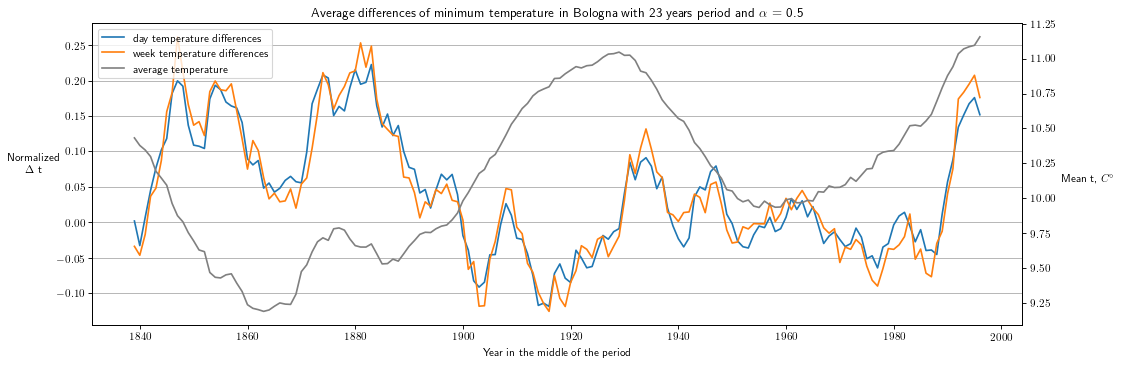

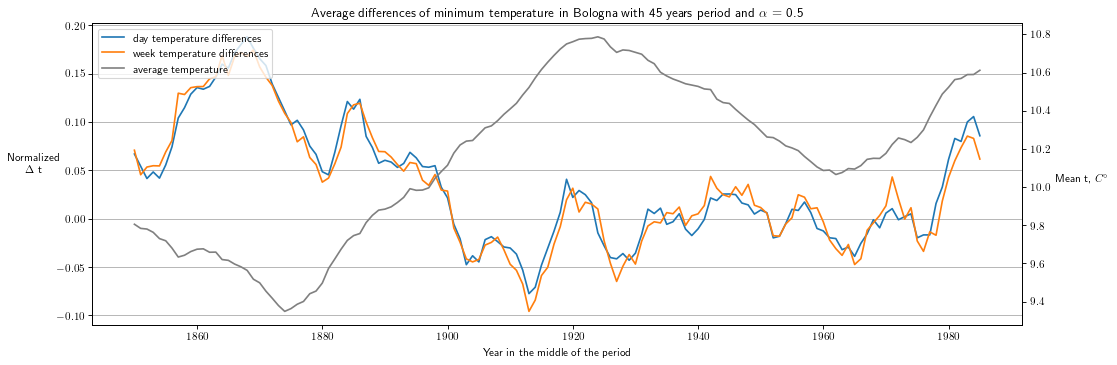

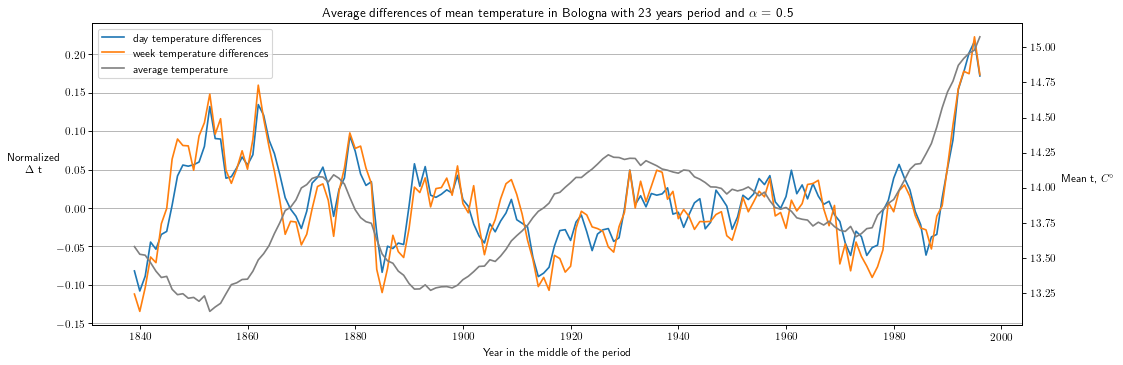

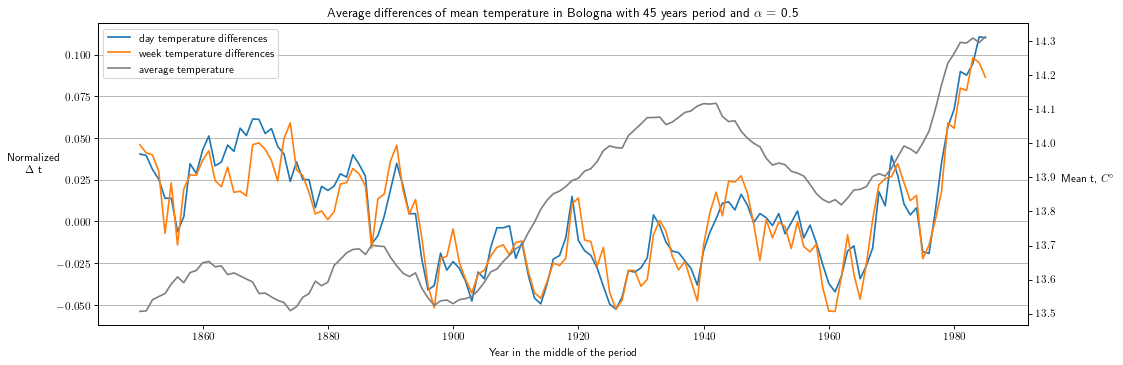

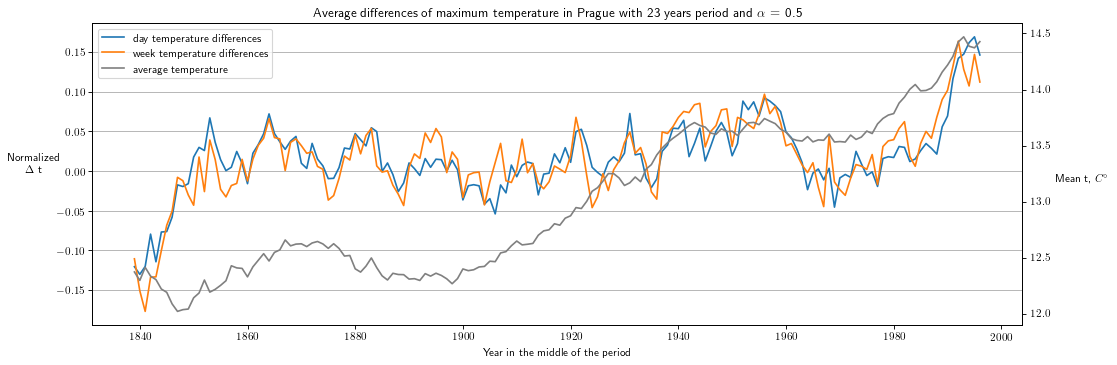

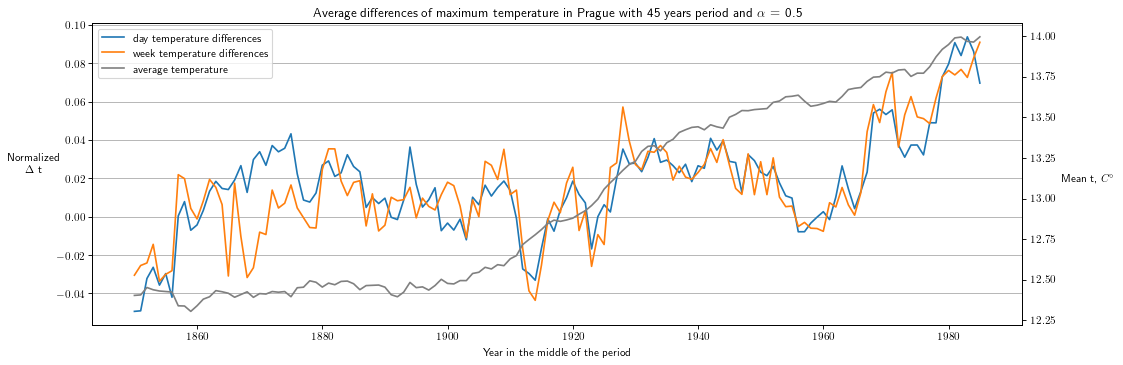

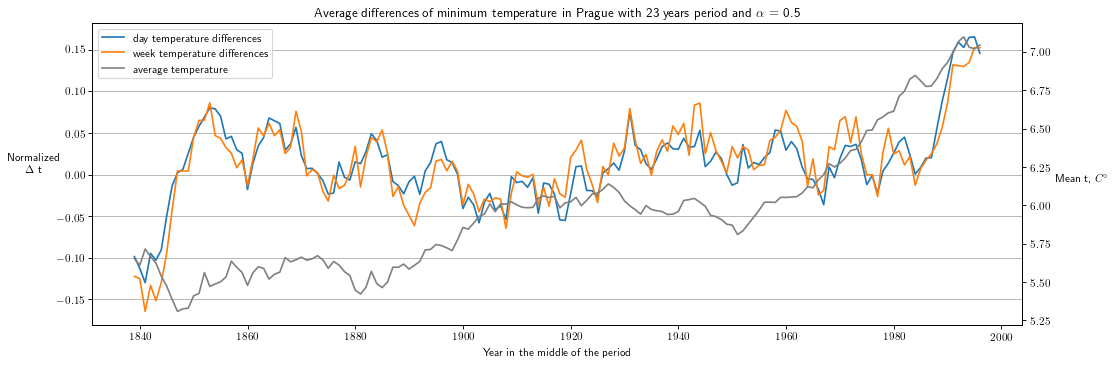

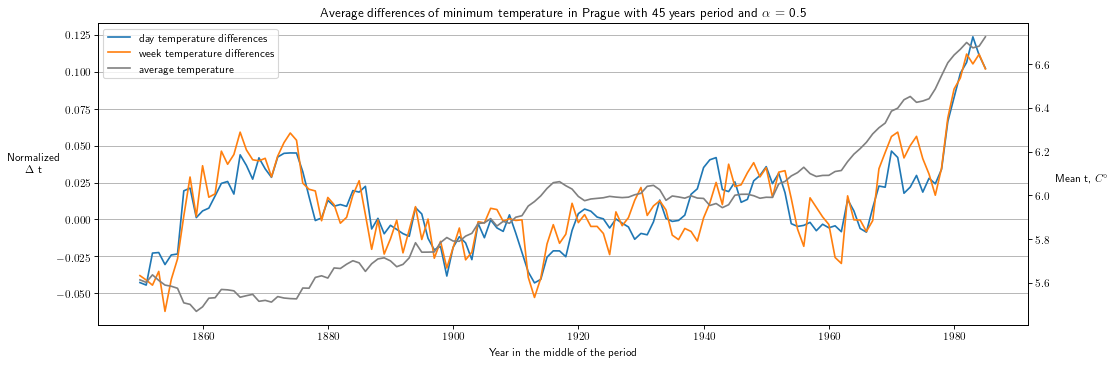

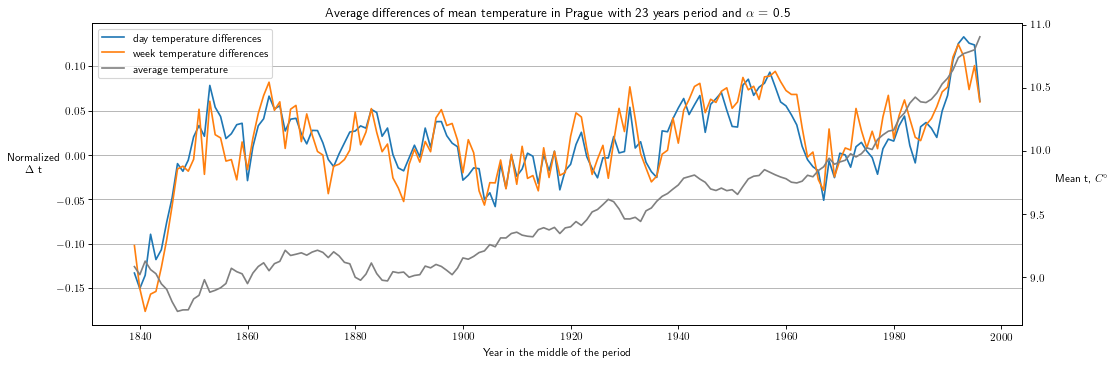

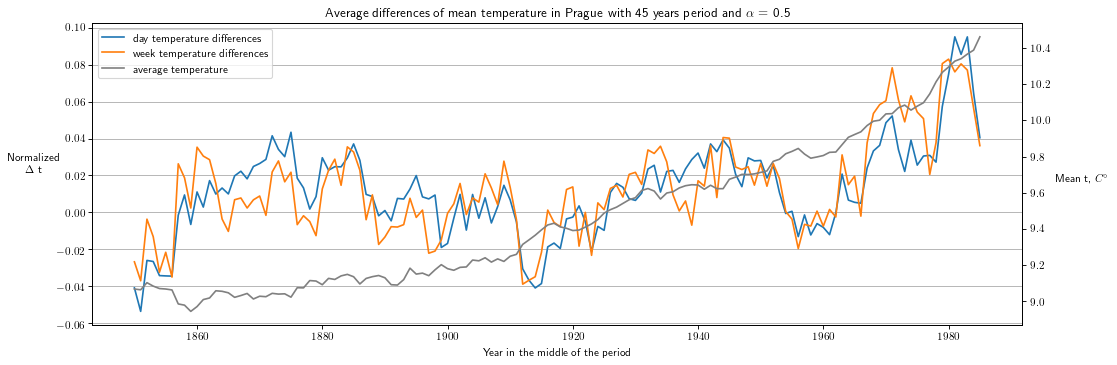

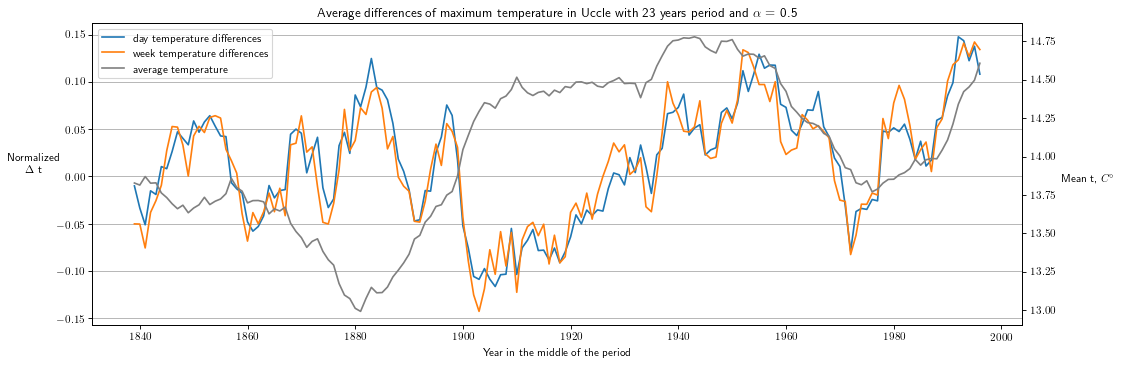

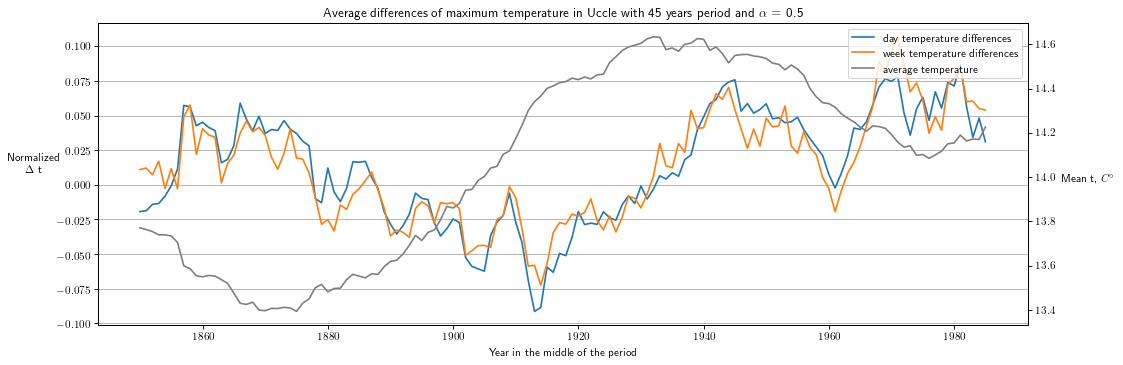

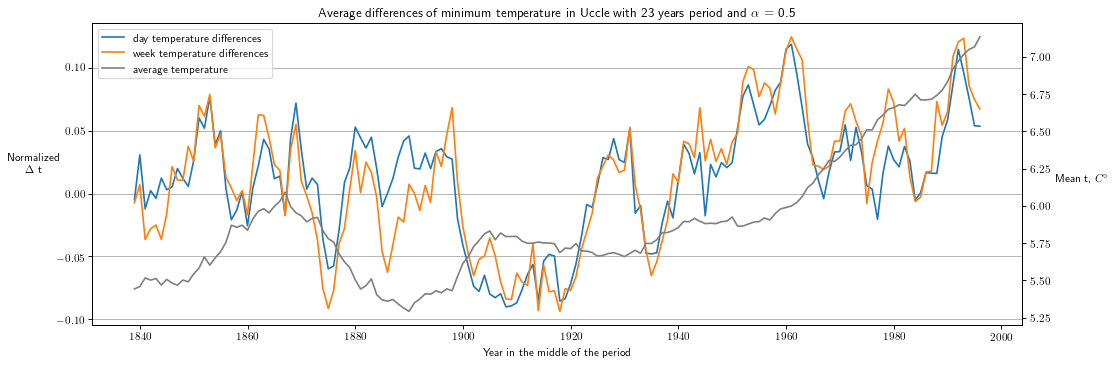

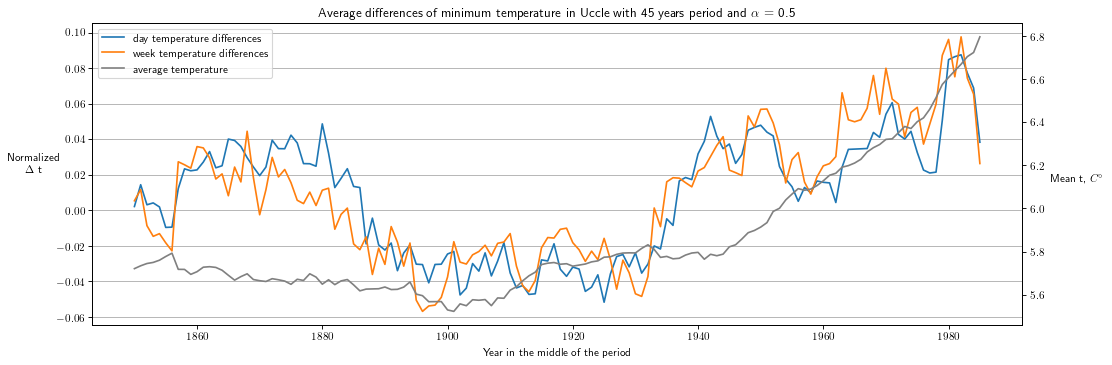

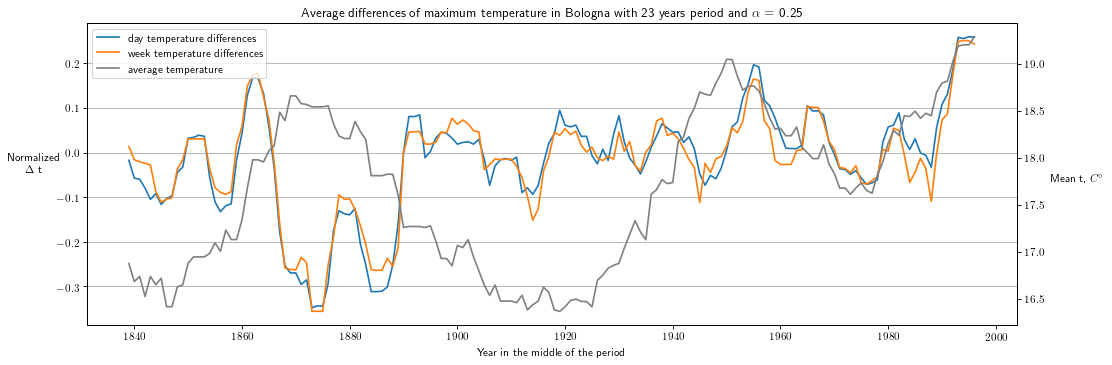

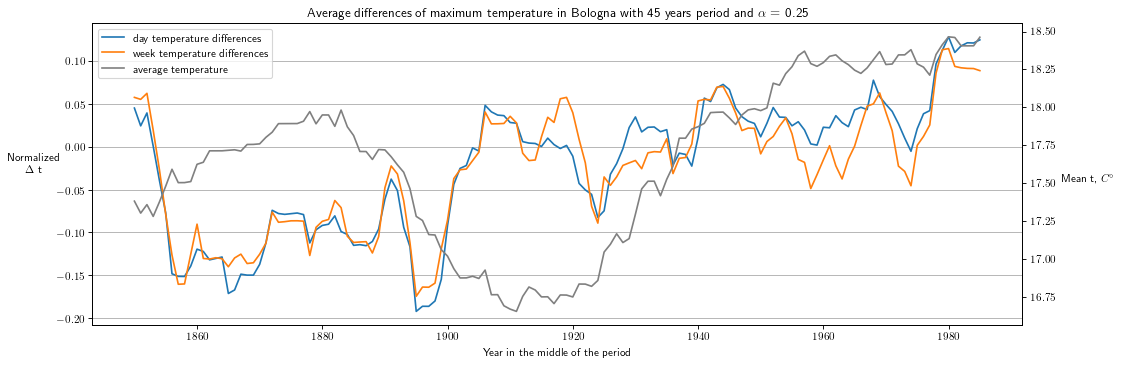

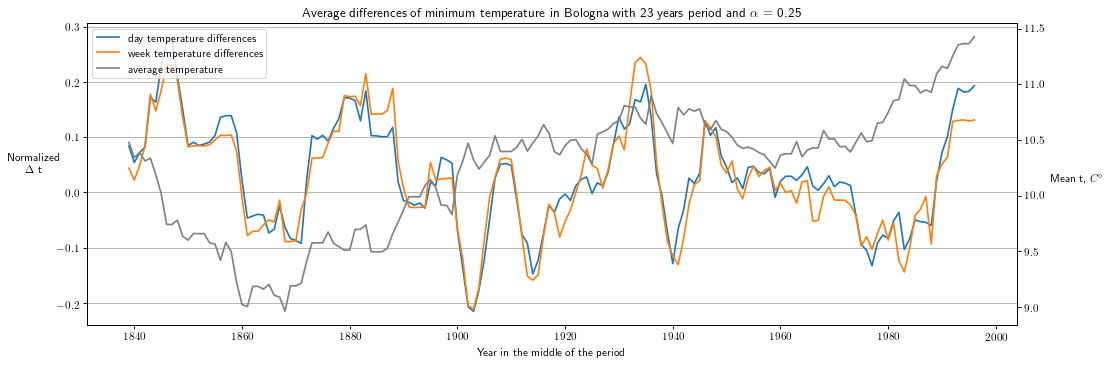

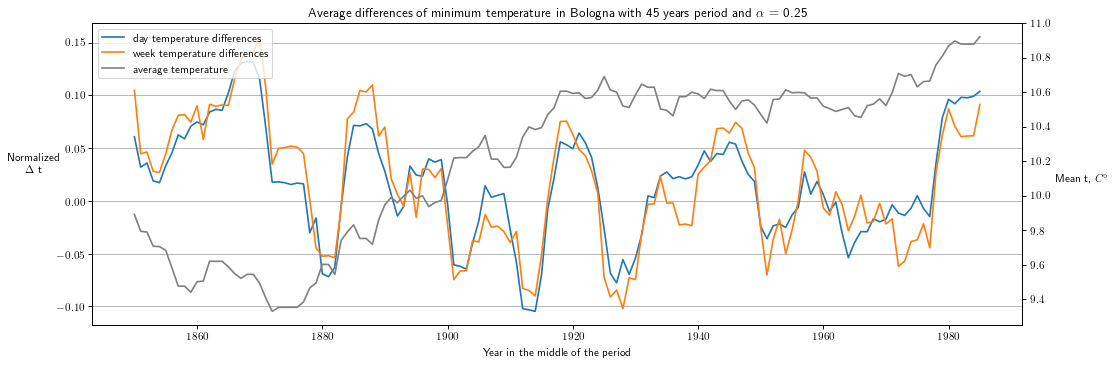

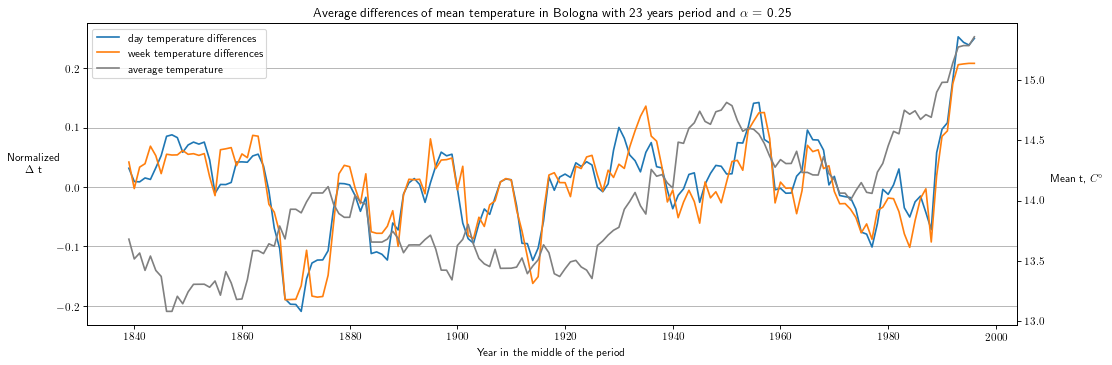

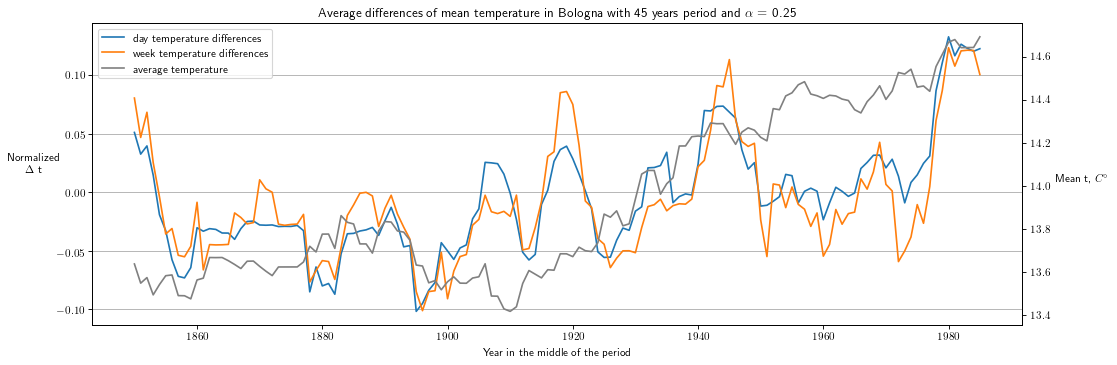

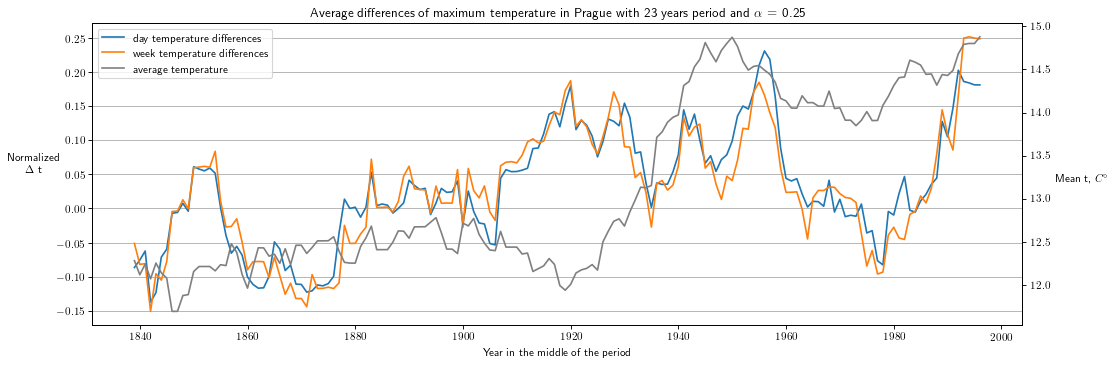

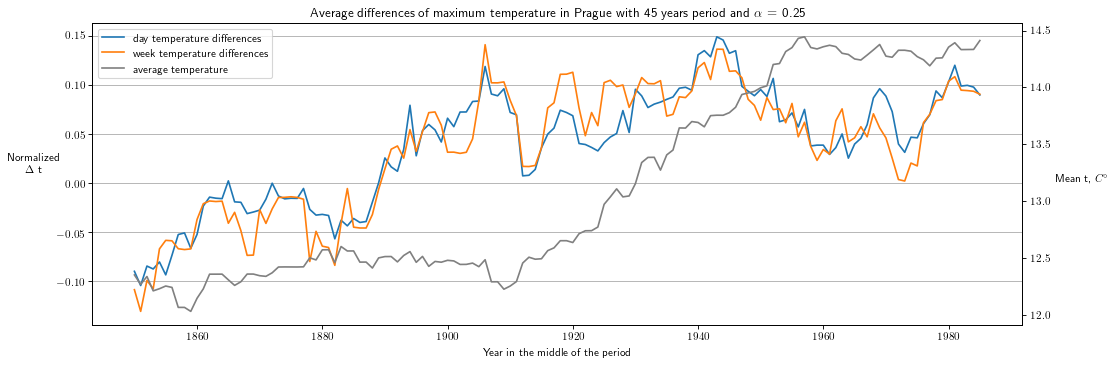

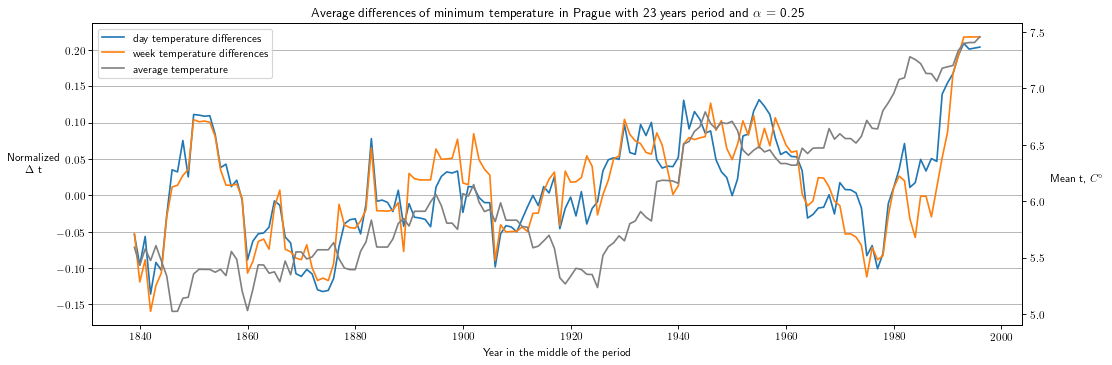

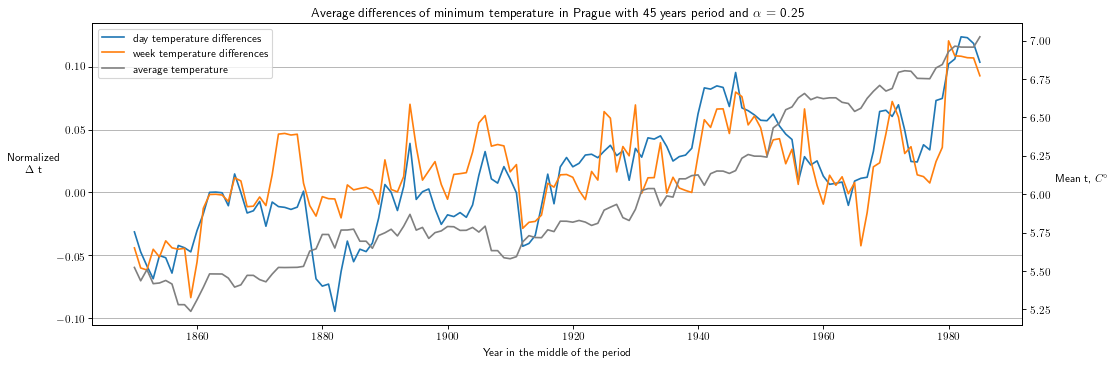

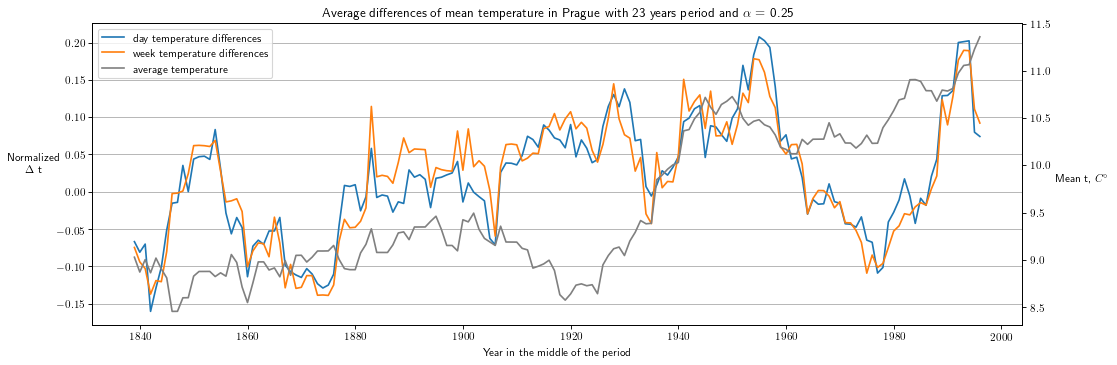

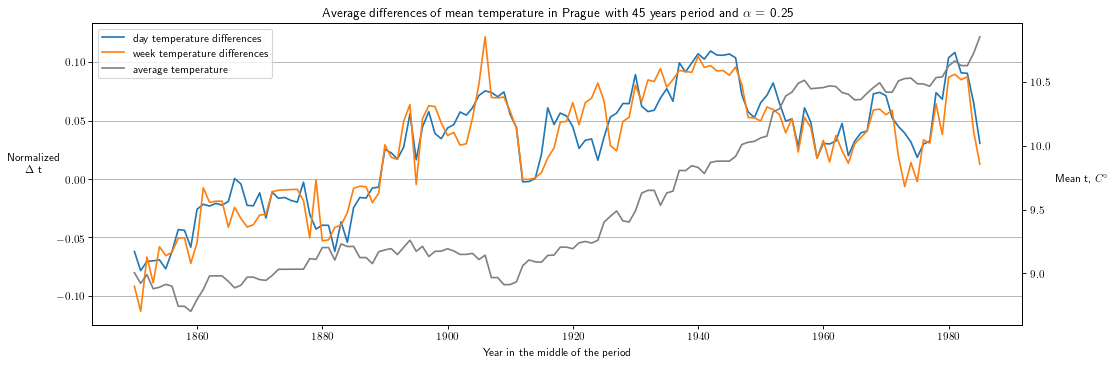

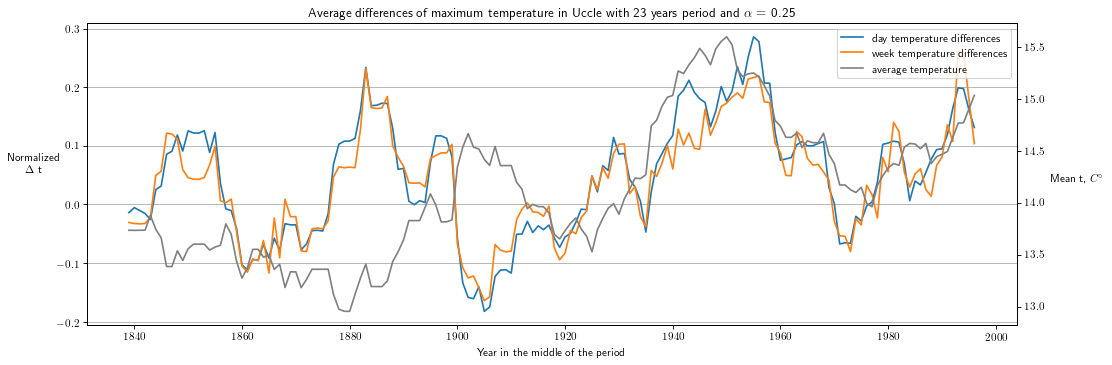

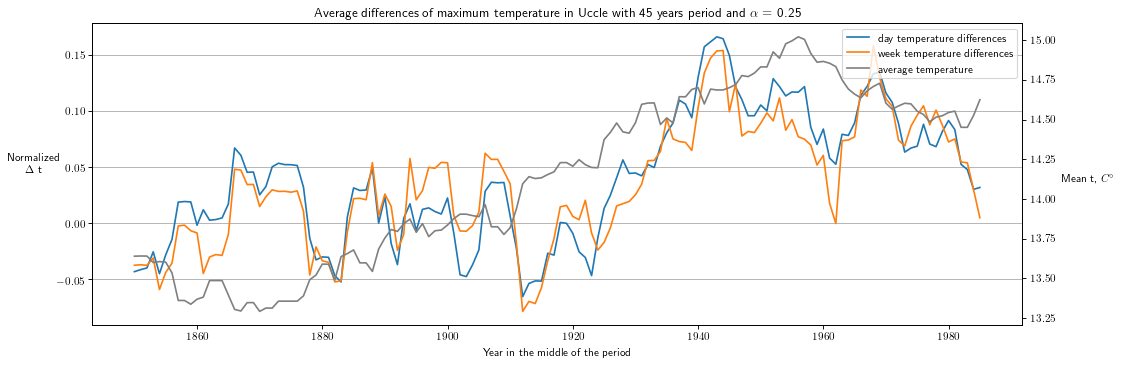

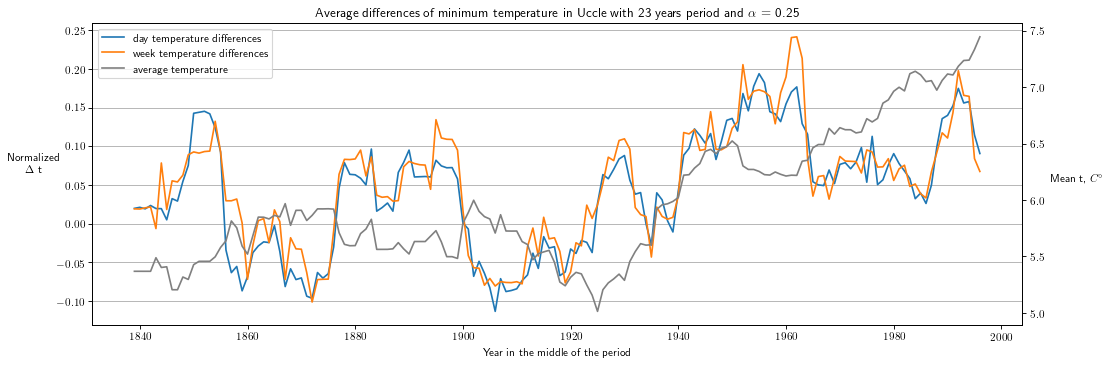

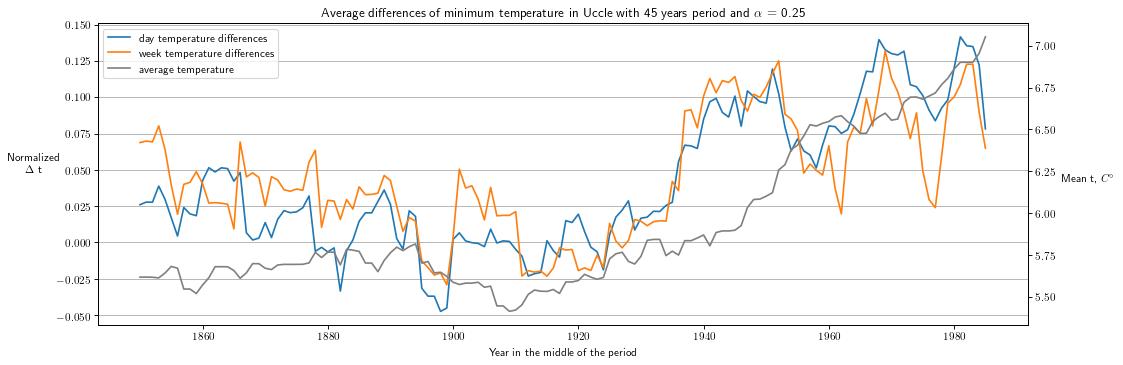

In [13]:
for alpha in [0.5, 0.25]:
    low_activity, high_activity = GetActivityLevels(alpha)
    for city in cities:
        for case in cases[city]:
            for period in [11, 22]:
                pic_name = GetPicName(city, case, f"median_diff_changing_{int(alpha*100)}_{period}")

                years, day_diff, week_diff, mean_temp, mean_delta = [], [], [], [], []
                for year in range(BEGIN + period + 10, END - period - 10):
                    begin, end = year - period, year + period + 1
                    delta = MeanDiff(city, case, begin, end, low_activity, high_activity)
                    day_diff.append(delta[0])
                    week_diff.append(delta[1])
                    mean_temp.append(delta[2])
                    years.append(year)
                years, day_diff, week_diff = np.array(years), np.array(day_diff), np.array(week_diff)                
                fig = plt.figure(dpi=DPI, figsize=(SIZE_X, SIZE_Y))
                ax1 = plt.axes()
                ax1.yaxis.grid(True)               
                ax2 = ax1.twinx()
                plt.title(f"Average differences of {full[case]} temperature in {city} "
                          f"with {2 * period + 1} years period and $\\alpha$ = {alpha}")
                ax1.set_xlabel("Year in the middle of the period")
                ax1.set_ylabel("Normalized \n $\Delta$ t", rotation="horizontal", labelpad=20)
                ax2.set_ylabel("Mean t, $C^{\circ}$", rotation="horizontal", labelpad=30)
                line1 = ax1.plot(years, 
                                day_diff, 
                                label="day temperature differences")
                line2 = ax1.plot(years, 
                                week_diff, 
                                label="week temperature differences")
                line3 = ax2.plot(years, 
                                mean_temp,
                                label="average temperature", 
                                color="grey")
                
                lines = line1 + line2 + line3
                labels = [l.get_label() for l in lines]
                plt.legend(lines, labels, loc="best")
                plt.show()
                fig.savefig(pic_name)

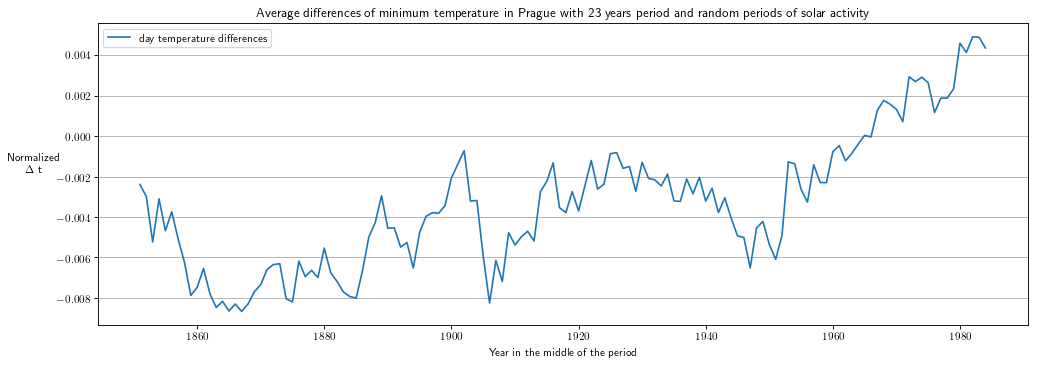

In [20]:
def GetRandomPeriods(start_day, finish_day, amount):
    low_activity, high_activity = set(), set()
    length = (finish_day - start_day) // amount
    low_periods = random.sample(range(amount), 11)
    for i in range(amount):
        start, finish = start_day + length * i, start_day + length * (i + 1)
        
        for day in range(start, finish):
            if day in date_by_number:
                if i in low_periods:
                    low_activity.add(date_by_number[day])
                else:
                    high_activity.add(date_by_number[day])
    return (low_activity, high_activity)

big_number = 100
period = 11
years = np.array(range(BEGIN + period + 10, END - period - 10))

for city in cities:
    for case in cases[city]:
        day_diff = [[] for i in range(big_number)]
        for i in range(big_number):
            low_activity, high_activity = set(), set()
            for j in range(len(days_of_minimum) - 1):
                start, finish = days_of_minimum[j], days_of_minimum[j + 1]
                tmp = GetRandomPeriods(start, finish, period)
                low_activity = low_activity.union(tmp[0])
                high_activity = high_activity.union(tmp[1])

            for year in years:
                begin, end = year - period, year + period + 1
                delta = MeanDiff(city, case, begin, end, low_activity, high_activity)
                day_diff[i].append(delta[0])


        day_diff = np.mean(np.array(day_diff), axis=0)
        pic_name = GetPicName(city, case, "random")
        fig = plt.figure(dpi=DPI, figsize=(SIZE_X, SIZE_Y))
        ax1 = plt.axes()
        ax1.yaxis.grid(True)               
        plt.title(f"Average differences of {full[case]} temperature in {city} "
                          f"with {2*period + 1} years period and random periods of solar activity")
        ax1.set_xlabel("Year in the middle of the period")
        ax1.set_ylabel("Normalized \n $\Delta$ t", rotation="horizontal", labelpad=20)
        line = ax1.plot(years, day_diff, label="day temperature differences")
        plt.legend(loc="best")
        plt.show()
        fig.savefig(pic_name)